# PCA analysis

## Aim

The intention of this notebook is to generate the PCA analysis and plots.

Steps to generate a PCA include removing related individuals, pruning variants in linkage disequilibrium (LD), and excluding outlier samples that can suggest poor genotyping quality or distant relatedness (also restrict to individuals of homogeneous ancestry).

Pitfalls
1. Some of the PCs may capture LD structure rather than population structure (decrease in power to detect associations in these regions of high LD)
2. When projecting a new study dataset to the PCA space computed from a reference dataset: projected PCs are shrunk toward 0 in the new dataset 
3.  PC scores may capture outliers that are due to family structure, population structure or other reasons; it might be beneficial to detect and remove these individuals to maximize the population structure captured by PCA (in the case of removing a few outliers) or to restrict analyses to genetically homogeneous samples


## Input

1. genotype files in plink format (`.bed`, `.bim` and `.fam`)
2. relatedness file (you can calculate relatedness using plink or king)

## Output

1. 

## PCA analysis pipeline

In [ ]:
[global]
# the output directory for generated files
parameter: cwd = path
# BED Plink files for exome data
parameter: bedfiles = paths
# BIM Plink files for exome data
parameter: bimfiles = paths
# The fam file associated to the bed files
parameter: famFile = path 
# The database to extract info from
parameter: database = path
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Number of threads
parameter: numThreads = 1

# Load Eigensoft module from cluster
parameter: eigensoft_module = '''
module load EIGENSOFT/7.2.1-foss-2018b
echo "Module Eigensoft v.7.2.1 loaded"
{cmd}
'''
# Software container option
parameter: container_lmm = 'statisticalgenetics/lmm:1.4'

In [ ]:
# Filter individuals from ancestries different than British, Irish, Other white background, prefer not to answer, do not know
[filter_1: provides = [f'{cwd}/cache/{famFile:bn}.white_ind']]
output: f'{cwd}/cache/{famFile:bn}.white_ind', f'{cwd}/cache/{famFile:bn}.white_ind.pheno'
task: trunk_workers = 1, walltime = '10h', mem = '40G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: container=container_lmm, expand= "${ }", stderr = f'{_output[0]:nn}.stderr', stdout = f'{_output[0]:nn}.stdout'
    #Load libraries
    library('dplyr')
    # This database is the one from June 2020 and contains a subset of variables with the PCs
    fam <- read.table(${famFile:r}, sep=' ', header=F)
    colnames(fam) <- c("FID","IID","fatherID", "motherID", "sex", "phenotype")
    cat("There are",nrow(fam),"individuals with exomes.\n")
    bd <- read.table(${database:r}, sep="\t", header=T)
    cat("The size of the full database is",dim(bd),".\n")
    # Assign individual ID column to bd f.eid
    names(bd)[1] <- "IID"
    # Select the 200K individuals with exomes from the full db
    exomed_IID <- bd[bd$IID %in% fam$IID,]
    cat("The number of selected individuals is",nrow(exomed_IID),".\n")
    # Filter db based on ethnicity variable
    ethnicity <- exomed_IID %>%
          select(IID, starts_with("f.21000"))
    # Function to extract all the available answers for 3 visits and put them in one list
    f<-function(x){
      visit<-c()
      for (i in 2:4){
        if (!is.na(x[i]))
        {visit<-c(visit,x[i])}
      }
      if(is.null(visit)){visit=NA}
      else{visit=as.numeric(visit)}
      return (visit)
    }

    # Apply the above function and remove NAs
    ethnicity$visit<-apply(ethnicity, 1, f)
    # Filter out individuals wih missing values in ethnicity: 212 ind total
    ethnicity <- ethnicity %>%
      filter(!is.na(visit))
    cat("There are",nrow(ethnicity),"individuals without missing values for ethnicity.\n")
    # Identify the unique available codings in f.21000
    code<-union(union(unique(ethnicity$f.21000.0.0),unique(ethnicity$f.21000.1.0)),unique(ethnicity$f.21000.2.0))
    # Codes to keep white individuals
    useful_code<-c(1001,1002,1003,1,-3,-1)
    # the rest that don’t have the combinations above can be set as NA
    useless_code<-code[!code %in% useful_code] 
    useless_code<-useless_code[-which(is.na(useless_code))] # remove NA here in the vector
    # Function to get the final code for ethnicity
    f<-function(x){
      l=length(unique(x$visit))
      if (l==1){ # only one value available
        result=unique(x$visit)
      }
      else{ # more then one value available
        l=length(x$visit)
        for (i in 1:l){
          if (x$visit[i] %in% useless_code){result=NA; break} # inconsistent ones with conbination not wanted
          else {result=9000} # inconsistent ones with right conbination
        }
      }
      return(result)
    }

    # Apply the above function and remove NAs
    ethnicity$new_ethnicity<-apply(ethnicity, 1, f)
    # Filter by NA presence
    ethnicity_noNA<-ethnicity %>%
      filter(!is.na(new_ethnicity))
    cat("There are",nrow(ethnicity_noNA),"individuals consistent for f.21000.\n")
    ethnicity_isNA <- ethnicity %>%
      filter(is.na(new_ethnicity))
    cat("There are",nrow(ethnicity_isNA),"individuals inconsistent for f.21000.\n")
    # keep only white individuals
    white <- ethnicity_noNA %>%
        filter(new_ethnicity %in% c(1,1001,1002,1003,-3,-1,9000)) %>%
        mutate(FID = IID) %>%
        select(FID,IID)
    cat("After excluding non-white ethnic backgrounds, the number of white individuals is",nrow(white),".\n")
    # Write the seleted individuals to a txt file
    write.table(white,${_output[0]:r}, sep="\t", row.names=FALSE, col.names=F)
    # Create the phenotype file
    pheno <- ethnicity_noNA %>%
        filter(new_ethnicity %in% c(1,1001,1002,1003,-3,-1,9000)) %>%
        mutate(ethnicity = new_ethnicity) %>%
        select(IID,ethnicity)
    # Merge the two data frames
    famfile <-merge(fam, pheno, by="IID", all=FALSE)
    cat("The famfile has ",nrow(famfile),"individuals.\n")
    write.table(famfile,${_output[1]:r}, sep="\t", row.names=FALSE, col.names=F)

In [ ]:
# Filter SNPs with MAF>1% for PCA analysis, select individuals and merge bed into one file
[filter_2]
parameter: maf_filter = 0.01
#Maximum missingess per-variant
parameter: geno_filter = 0.01
#Maximum missingness per-sample
parameter: mind_filter = 0.02
parameter: hwe_filter = 0.0
input: bedfiles, paired_with=['bimfiles'], group_by=1
depends: f'{cwd}/cache/{famFile:bn}.white_ind'
output: f'{cwd}/{_input:bn}.filtered.bed'
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: container=container_lmm, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', template = '{cmd}' if executable('plink2').target_exists() else plink2_module
    plink2 \
      --bed ${_input}  --bim ${_input._bimfiles} --fam ${famFile} \
      ${('--maf %s' % maf_filter) if maf_filter > 0 else ''} ${('--geno %s' % geno_filter) if geno_filter > 0 else ''} ${('--hwe %s' % hwe_filter) if hwe_filter > 0 else ''} ${('--mind %s' % mind_filter) if mind_filter > 0 else ''} \
      --keep ${_depends} \
      --make-bed \
      --threads ${numThreads} \
      --out ${_output:n} 

In [ ]:
# Merge all the .bed files into one bed file for input to eigensoft
[filter_3]
input: group_by = 'all'
output: bfile_merge = f'{cwd}/{famFile:bn}.filtered.merged.bed'
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '60G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', template = '{cmd}' if executable('plink').target_exists() else plink_module
    echo -e ${' '.join([str(x)[:-4] for x in _input[1:]])} | sed 's/ /\n/g' > ${_output:n}.merge_list
    plink \
    --bfile ${_input[0]:n} \
    --merge-list ${_output:n}.merge_list \
    --make-bed \
    --out ${_output:n} \
    --threads ${numThreads} \
    --memory 48000

In [ ]:
# LD prunning window=50, shift-window every 5 SNPS, r2=0.5
[filter_4]
parameter: window = 50
parameter: shift = 5
parameter: r2 = 0.5
output: f'{cwd}/{famFile:bn}.filtered.merged.prune.in', f'{cwd}/{famFile:bn}.filtered.merged.prune.bed'
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '60G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', template = '{cmd}' if executable('plink').target_exists() else plink_module
    plink \
    --bfile ${_input:n} \
    --indep-pairwise ${window} ${shift} ${r2}  \
    --out ${_output[0]:nn} \
    --threads ${numThreads} \
    --memory 48000
    
    plink \
    --bfile ${_input:n} \
    --extract ${_output[0]} \
    --make-bed \
    --out ${_output[1]:n} 

In [ ]:
# Run pca analysis using Eigenstrat: the program suports plink files here called PACKEDPED format
# smartpca.perl: run PCA on input genotype data (calls smartpca)
[pca_1]
# Number of Principal Components to output
parameter: k = int
# Maximum number of iterations for outlier removal. Default 0 turns off outlier removal
parameter: maxiter = 0
# Number of principal components along which to remove outliers during each outlier removal iteration. Default is 10
parameter: topk = 10
# Number of standard deviations which an individual must exceed, along one of topk top principal components, in order to be removed as an outlier. Default is 6
parameter: sigma = 6
input: f'{cwd}/{famFile:bn}.filtered.merged.bed'
output: f'{cwd}/{_input:bn}.convert.parfile' , 
        f'{cwd}/{_input:bn}.eigenstrat.parfile',
        f'{cwd}/{_input:bn}.snp', 
        f'{cwd}/{_input:bn}.ind', 
        f'{cwd}/{_input:bn}.geno', 
        f'{cwd}/{_input:bn}.evectout',
        f'{cwd}/{_input:bn}.evalout'
task: trunk_workers = 1, walltime = '24h', mem = '80G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand= "${ }", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module
  #Create the parfile
  #The famFile does not accept -9 make sure you change this before 
  set -e
  echo -e "genotypename: ${_input}" >> ${_output[0]}
  echo -e "snpname: ${_input:n}.bim" >> ${_output[0]}
  echo -e "indivname: ${_input:n}.eigenstrat.fam" >> ${_output[0]}
  echo -e "outputformat: EIGENSTRAT" >> ${_output[0]}
  echo -e "fastmode: YES" >> ${_output[0]}
  echo -e "genotypeoutname: ${_input:n}.geno" >> ${_output[0]}
  echo -e "snpoutname: ${_input:n}.snp" >> ${_output[0]}
  echo -e "indivoutname: ${_input:n}.ind" >> ${_output[0]}
  
  echo -e "genotypename: ${_input:n}.geno" >> ${_output[1]}
  echo -e "snpname: ${_input:n}.snp" >> ${_output[1]}
  echo -e "indivname: ${_input:n}.ind" >> ${_output[1]}
  echo -e "fastmode: YES" >> ${_output[1]}
  echo -e "evectoutname: ${_input:n}.evectout" >> ${_output[1]}
  echo -e "evaloutname: ${_input:n}.evalout" >> ${_output[1]} 
  echo -e "numoutevec: ${k}" >> ${_output[1]} 
  echo -e "numoutlieriter: ${maxiter}" >> ${_output[1]} 
  echo -e "numoutlierevec: ${topk}" >> ${_output[1]} 
  echo -e "outliersigmathresh: ${sigma}" >> ${_output[1]} 
  

bash: expand= "${ }", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module
   
   convertf -p ${_output[0]}
   
bash: expand= "${ }", stderr = f'{_output[1]}.stderr', stdout = f'{_output[1]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module
  
   smartpca -p ${_output[1]}

In [1]:
# Test run using the smartpca.perl version without parameter file
#FIXME: error OOPS -a flag not specified at /gpfs/ysm/apps/software/EIGENSOFT/7.2.1-foss-2018b/bin/smartpca.perl line 21.
# /tmp/tmp5ywa_r4f.sh: line 4: -a: command not found
[smartpca]
# Number of Principal Components to output
parameter: k = int
# Maximum number of iterations for outlier removal. Default 0 turns off outlier removal
parameter: maxiter = 0
# Number of principal components along which to remove outliers during each outlier removal iteration. Default is 10
parameter: topk = 10
# Number of standard deviations which an individual must exceed, along one of topk top principal components, in order to be removed as an outlier. Default is 6
parameter: sigma = 6
input: f'{cwd}/{famFile:bn}.filtered.merged.geno'
output: f'{cwd}/{_input:bn}.eigenstrat.pca',
        f'{cwd}/{_input:bn}.eigenstrat.plot',
        f'{cwd}/{_input:bn}.eigenstrat.eigenvalues'
task: trunk_workers = 1, walltime = '24h', mem = '80G', cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "${ }", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module

    smartpca.perl \
    -i ${_input} \ 
    -a ${_input:n}.snp \
    -b ${_input:n}.ind \
    -k ${k} \
    -o ${_output[0]} \
    -p ${_output[2]} \
    -e ${_output[1]} \
    -l ${_output[0]:n}.log \
    -m ${maxiter} \
    -t ${topk} \
    -s ${sigma}

In [ ]:
# Run pca analysis using Eigenstrat: the program suports plink files here called PACKEDPED format
# smartpca.perl: run PCA on input genotype data (calls smartpca)
[smartpca]
# Number of Principal Components to output
parameter: k = int
# Maximum number of iterations for outlier removal. Default 0 turns off outlier removal
parameter: maxiter = 0
# Number of principal components along which to remove outliers during each outlier removal iteration. Default is 10
parameter: topk = 10
# Number of standard deviations which an individual must exceed, along one of topk top principal components, in order to be removed as an outlier. Default is 6
parameter: sigma = 6
input: f'{cwd}/{famFile:bn}.filtered.merged.bed'
output: f'{cwd}/{_input:bn}.parfile' ,  f'{cwd}/{_input:bn}.pca'
task: trunk_workers = 1, walltime = '24h', mem = '80G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand = "${ }", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module
  #Create the parfile
  set -e
  echo -e "genotypename: ${_input}" >> ${_output[0]}
  echo -e "snpname: ${_input:n}.bim" >> ${_output[0]}
  echo -e "indivname: ${_input:n}.eigenstrat.fam" >> ${_output[0]}
  echo -e "outputformat: EIGENSTRAT" >> ${_output[0]}
  echo -e "fastmode: YES" >> ${_output[0]}
  echo -e "genotypeoutname: ${_input:n}.geno" >> ${_output[0]}
  echo -e "snpoutname: ${_input:n}.snp" >> ${_output[0]}
  echo -e "indivoutname: ${_input:n}.ind" >> ${_output[0]}
  echo -e "evectoutname: ${_input:n}.evectout" >> ${_output[0]}
  echo -e "evaloutname: ${_input:n}.evalout" >> ${_output[0]} 
  echo -e "numoutevec: ${k}" >> ${_output[0]} 
  echo -e "numoutlieriter: ${maxiter}" >> ${_output[0]} 
  echo -e "numoutlierevec: ${topk}" >> ${_output[0]} 
  echo -e "outliersigmathresh: ${sigma}" >> ${_output[0]} 
  

bash: expand = "${ }", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module
   convertf -p ${_output[0]}
   #smartpca -p ${_output[0]}

In [ ]:
# Run PCA analysis using flashpca
[flashpca]
#Number of Principal Components to output. Default is 10
parameter: k = int
#How to standardize X before PCA
parameter: stand = "binom2"
input: f'{cwd}/{famFile:bn}.filtered.merged.prune.bed', f'{cwd}/cache/{famFile:bn}.white_ind.pheno'
output: f'{cwd}/{_input[0]:bn}.pca',
        f'{cwd}/{_input[0]:bn}.pc1vpc2.png',
        f'{cwd}/{_input[0]:bn}.pc3vpc4.png',
        f'{cwd}/{_input[0]:bn}.pc5vpc6.png' 
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    # Load required libraries
    library(dplyr)
    library(ggplot2)
    library(flashpcaR)
    # Read the PLINK binary files
    fn <- ${_input[0]:nr}
    # Do the PCA computation
    f <- flashpca(fn, ndim=${k}, stand="${stand}", do_loadings=TRUE, check_geno=TRUE)
    # Save the generated matrices to files
    write.table(f$values,'${_output[0]:n}.values', sep=" ", row.names=FALSE, col.names=F) 
    write.table(f$vectors,'${_output[0]:n}.vectors', sep=" ", row.names=TRUE, col.names=F)
    write.table(f$projection,'${_output[0]:n}.projection', sep=" ", row.names=TRUE, col.names=F)
    write.table(f$loadings,'${_output[0]:n}.loadings', sep=" ", row.names=FALSE, col.names=F)
    write.table(f$scale,'${_output[0]:n}.scale', sep=" ", row.names=FALSE, col.names=F)
    # Use the projection file to generate plot
    pca <- read.table('${_output[0]:n}.projection', sep=" ")
    colnames(pca) <- c("ID","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    pca$IID <- sapply(strsplit(as.character(pca$ID),':'), "[", 1)
    # Read fam file with phenotypes
    fam <- read.table(${famFile:r}, sep=" ")
    colnames(fam) <- c("FID", "IID", "father", "mother","sex", "pheno")
    ind <-merge(fam, pca, by="IID", all=TRUE)
    # Read the file with ethnicity values
    ethnicity <- read.table(${_input[1]:r}, sep="\t" )
    colnames(ethnicity) <- c("FID", "IID", "father", "mother","sex", "pheno", "ethnicity")
    # Create the final PCA + ethnicity file
    pca_final <-merge(ind, ethnicity, by="IID",all.y=FALSE)
    pca_final_r <- pca_final %>% 
        mutate(ethnicity_1 = case_when(
             ethnicity == 1001 ~  "British",
             ethnicity == 1002 ~ "Irish",
             ethnicity == 1003 ~ "Any other white background",
             ethnicity == 9000 ~ "Inconsistent_white",
             ethnicity == 1 ~ "White",
             ethnicity == -1 ~ "Do not know",
             ethnicity == -3 ~ "Prefer not to answer",
             TRUE  ~ ""))
    write.table(pca_final_r,${_output[0]:r}, sep="\t", quote=FALSE, row.names=FALSE, col.names=T)
  
    png('${_output[1]}', width = 6, height = 4, unit='in', res=300)
    ggplot(pca_final_r, aes(x=PC1, y=PC2)) + geom_point(aes(color=ethnicity_1)) + labs(title="PC1 vs PC2 exomed subset white",x="PC1", y = "PC2") + theme_classic()
    dev.off()
  
    png('${_output[2]}', width = 6, height = 4, unit='in', res=300)
    ggplot(pca_final_r, aes(x=PC3, y=PC4)) + geom_point(aes(color=ethnicity_1)) + labs(title="PC3 vs PC4 exomed subset white", x="PC3", y = "PC4") + theme_classic()
    dev.off()
    
    png('${_output[3]}', width = 6, height = 4, unit='in', res=300)
    ggplot(pca_final_r, aes(x=PC5, y=PC6)) + geom_point(aes(color=ethnicity_1)) + labs(title="P5 vs PC6 exomed subset white",x="PC5", y = "PC6") + theme_classic()
    dev.off()           

# Calculate mahalanobis distance to remove outliers

In [1]:
setwd("/gpfs/gibbs/pi/dewan/data/UKBiobank/results/pca_exomes")
pca <- read.csv("ukb23155_s200631.filtered.merged.prune.pca", sep='\t')
head(pca)

,IID,FID.x,father.x,mother.x,sex.x,pheno.x,ID,PC1,PC2,PC3,⋯,PC8,PC9,PC10,FID.y,father.y,mother.y,sex.y,pheno.y,ethnicity,ethnicity_1
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
1,1000019,1000019,0,0,2,-9,1000019:1000019,0.01553941,0.02393847,-0.007491376,⋯,-0.0008964522,0.005746197,-0.001042337,1000019,0,0,2,-9,1001,British
2,1000035,1000035,0,0,1,-9,1000035:1000035,0.01253709,-0.02193925,0.003917083,⋯,-0.0101081273,0.003216692,-0.011721235,1000035,0,0,1,-9,1001,British
3,1000078,1000078,0,0,2,-9,1000078:1000078,0.01497620,0.01950002,0.013263954,⋯,0.0199936269,-0.004632490,-0.004389401,1000078,0,0,2,-9,1001,British
4,1000081,1000081,0,0,1,-9,1000081:1000081,-0.12213015,0.03863465,0.003532455,⋯,-0.0108502715,0.015511705,0.006788431,1000081,0,0,1,-9,1001,British
5,1000198,1000198,0,0,2,-9,1000198:1000198,0.01218179,0.02232563,-0.007680613,⋯,-0.0026506194,-0.012875036,0.004556960,1000198,0,0,2,-9,1001,British
6,1000210,1000210,0,0,1,-9,1000210:1000210,0.02526840,0.03664394,0.001277694,⋯,-0.0023364127,0.016794410,-0.012663409,1000210,0,0,1,-9,1001,British


In [5]:
library(dplyr)
pc = pca %>%
    select("IID", "ethnicity_1", starts_with("PC"),)
head(pc)
nrow(pc)

,IID,ethnicity_1,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000019,British,0.01553941,0.02393847,-0.007491376,-0.005710133,0.008875987,-0.000270289,-0.0002785837,-0.0008964522,0.005746197,-0.001042337
2,1000035,British,0.01253709,-0.02193925,0.003917083,0.006284067,-0.010311789,0.025505354,-0.0069599583,-0.0101081273,0.003216692,-0.011721235
3,1000078,British,0.01497620,0.01950002,0.013263954,-0.018580038,0.006379030,-0.001985547,0.0100692105,0.0199936269,-0.004632490,-0.004389401
4,1000081,British,-0.12213015,0.03863465,0.003532455,-0.002797373,-0.017269542,-0.017946452,-0.0181935503,-0.0108502715,0.015511705,0.006788431
5,1000198,British,0.01218179,0.02232563,-0.007680613,0.002397714,-0.023268540,0.010575808,-0.0021913240,-0.0026506194,-0.012875036,0.004556960
6,1000210,British,0.02526840,0.03664394,0.001277694,-0.004001638,-0.003573630,0.015393983,0.0034119557,-0.0023364127,0.016794410,-0.012663409


[1] 189016

In [11]:
library(stats)
#pc= pca %>%
# select(starts_with("PC"))
pc$mahal <- mahalanobis(pc[,3:12], center=FALSE, PC_cov)
pc$p <- pchisq(pc$mahal, df=9, lower.tail=FALSE)
#df$mahal <- mahalanobis(df, colMeans(df), cov(df))

In [13]:
head(pc,100)

,IID,ethnicity_1,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,mahal,p
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000019,British,0.0155394129,0.0239384666,-0.0074913764,-0.0057101331,0.008875987,-0.0002702890,-2.785837e-04,-0.0008964522,0.005746197,-0.0010423370,2.429060,9.827308e-01
2,1000035,British,0.0125370899,-0.0219392473,0.0039170826,0.0062840671,-0.010311789,0.0255053537,-6.959958e-03,-0.0101081273,0.003216692,-0.0117212346,5.924084,7.474916e-01
3,1000078,British,0.0149761960,0.0195000166,0.0132639535,-0.0185800380,0.006379030,-0.0019855474,1.006921e-02,0.0199936269,-0.004632490,-0.0043894009,5.601559,7.790380e-01
4,1000081,British,-0.1221301450,0.0386346531,0.0035324548,-0.0027973729,-0.017269542,-0.0179464525,-1.819355e-02,-0.0108502715,0.015511705,0.0067884311,36.572611,3.136413e-05
5,1000198,British,0.0121817942,0.0223256284,-0.0076806131,0.0023977140,-0.023268540,0.0105758075,-2.191324e-03,-0.0026506194,-0.012875036,0.0045569595,5.099305,8.255671e-01
6,1000210,British,0.0252684016,0.0366439384,0.0012776941,-0.0040016377,-0.003573630,0.0153939830,3.411956e-03,-0.0023364127,0.016794410,-0.0126634095,7.395942,5.959687e-01
7,1000224,British,0.0212169236,0.0659584979,0.0133719243,0.0138321748,0.004248925,0.0077477960,-1.478203e-02,-0.0033844262,-0.001019759,-0.0078987052,12.819407,1.709496e-01
8,1000236,British,0.0036723942,0.0291931239,0.0034123487,-0.0202256850,0.003520475,-0.0032798451,5.676869e-03,-0.0047997813,0.007295340,-0.0057428548,4.027087,9.096207e-01
9,1000255,British,-0.0028560374,-0.0137288352,0.0056969483,-0.0121799240,0.006423018,0.0299984028,-4.628482e-04,-0.0269444708,0.035020187,0.0016431842,14.371275,1.097176e-01


In [16]:
length(which(pc$p < 2e-08))

[1] 1664

In [3]:
# calculate covariance of the features
PC_cov = cov(pc[,3:12])
head(PC_cov)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,5.421522e-04,-2.028804e-19,1.321268e-19,-7.259620e-20,4.653568e-20,-5.268156e-21,1.590150e-20,1.516786e-20,-1.785426e-20,3.954513e-21
PC2,-2.028804e-19,4.759236e-04,2.624618e-19,-5.135812e-20,-2.038693e-19,1.304438e-20,-1.149791e-20,1.245990e-19,-4.171724e-20,1.209127e-20
PC3,1.321268e-19,2.624618e-19,3.091152e-04,8.682135e-19,-1.053246e-19,-2.983784e-22,3.061795e-21,2.000894e-21,-1.256077e-19,2.692803e-20
PC4,-7.259620e-20,-5.135812e-20,8.682135e-19,2.925158e-04,7.200688e-19,-1.125105e-20,5.215969e-20,-2.465964e-19,-8.403623e-20,1.469338e-20
PC5,4.653568e-20,-2.038693e-19,-1.053246e-19,7.200688e-19,2.559794e-04,1.551328e-20,6.487266e-21,1.563918e-19,-1.609577e-19,3.474968e-20
PC6,-5.268156e-21,1.304438e-20,-2.983784e-22,-1.125105e-20,1.551328e-20,2.511973e-04,9.367256e-20,5.352686e-20,1.554402e-20,-3.532764e-21


In [4]:
# Find the inverse of the covariance matrix
inv_PC_cov = solve(PC_cov)
head(inv_PC_cov )

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,1.844501e+03,7.862881e-13,-7.884047e-13,4.577658e-13,-3.353203e-13,3.868320e-14,-1.243873e-13,-1.277873e-13,1.684596e-13,-3.759058e-14
PC2,7.862881e-13,2.101177e+03,-1.784056e-12,3.689118e-13,1.673438e-12,-1.091117e-13,1.024568e-13,-1.195809e-12,4.483873e-13,-1.309308e-13
PC3,-7.884047e-13,-1.784056e-12,3.235040e+03,-9.601893e-12,1.331080e-12,3.842660e-15,-4.200633e-14,-2.956571e-14,2.078600e-12,-4.489433e-13
PC4,4.577658e-13,3.689118e-13,-9.601893e-12,3.418619e+03,-9.616556e-12,1.531189e-13,-7.562140e-13,3.850544e-12,1.469577e-12,-2.588687e-13
PC5,-3.353203e-13,1.673438e-12,1.331080e-12,-9.616556e-12,3.906564e+03,-2.412590e-13,-1.074770e-13,-2.790575e-12,3.216486e-12,-6.996052e-13
PC6,3.868320e-14,-1.091117e-13,3.842660e-15,1.531189e-13,-2.412590e-13,3.980934e+03,-1.581453e-12,-9.732882e-13,-3.165361e-13,7.247811e-14


In [5]:
# Calculate the mean for each variable
PC_mean=apply(pc[,3:12], 2, mean)
head(PC_mean)

PC1           PC2           PC3           PC4           PC5 
-3.202909e-18 -1.909373e-17 -1.743195e-18 -9.957463e-18 -1.537211e-17 
          PC6 
 3.848268e-19

In [ ]:
manha_dis_sq = apply(pc[,3:12], 1, FUN=function(x){t(x-PC_mean)%*% inv_PC_cov %*% (x-PC_mean)})
manha_dis_sq

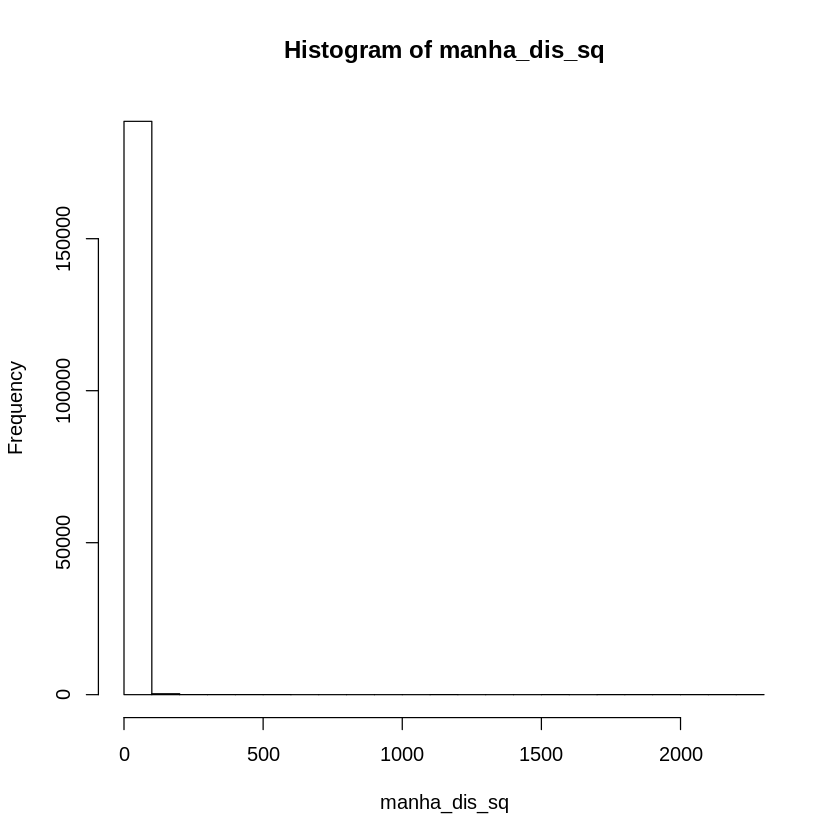

In [7]:
hist(manha_dis_sq)

In [8]:
sd(manha_dis_sq)

[1] 36.30221

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”


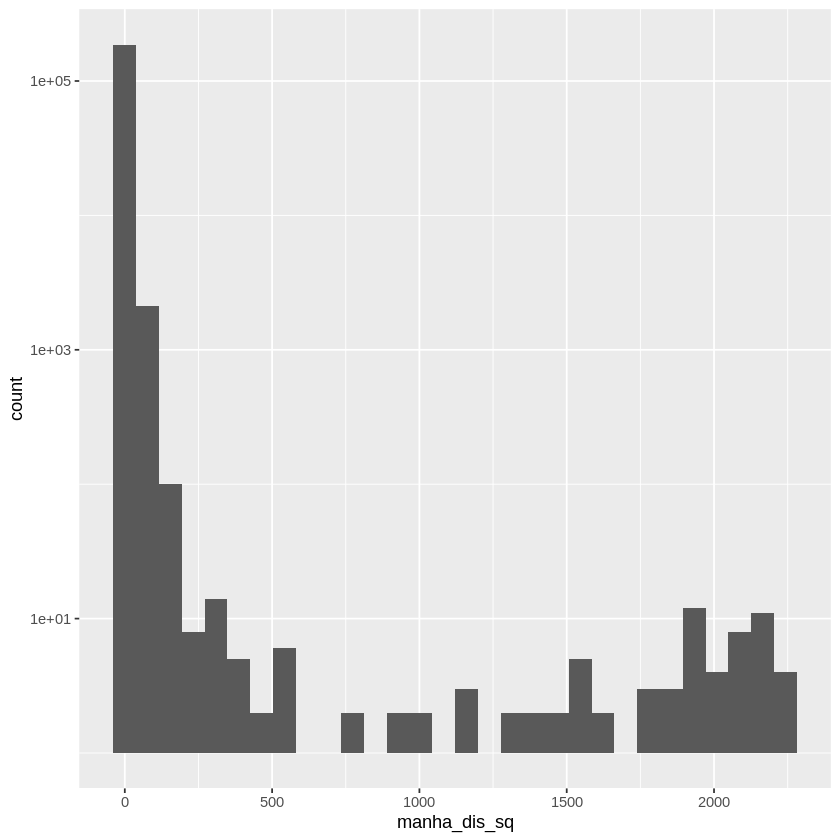

In [10]:
library(ggplot2)
ggplot() + geom_histogram(aes(manha_dis_sq)) + scale_y_log10()


In [14]:
length(which(manha_dis_sq >= manh_dis_sq_cutoff))

[1] 568

In [15]:
length(which(manha_dis_sq <= manh_dis_sq_cutoff))

[1] 188448

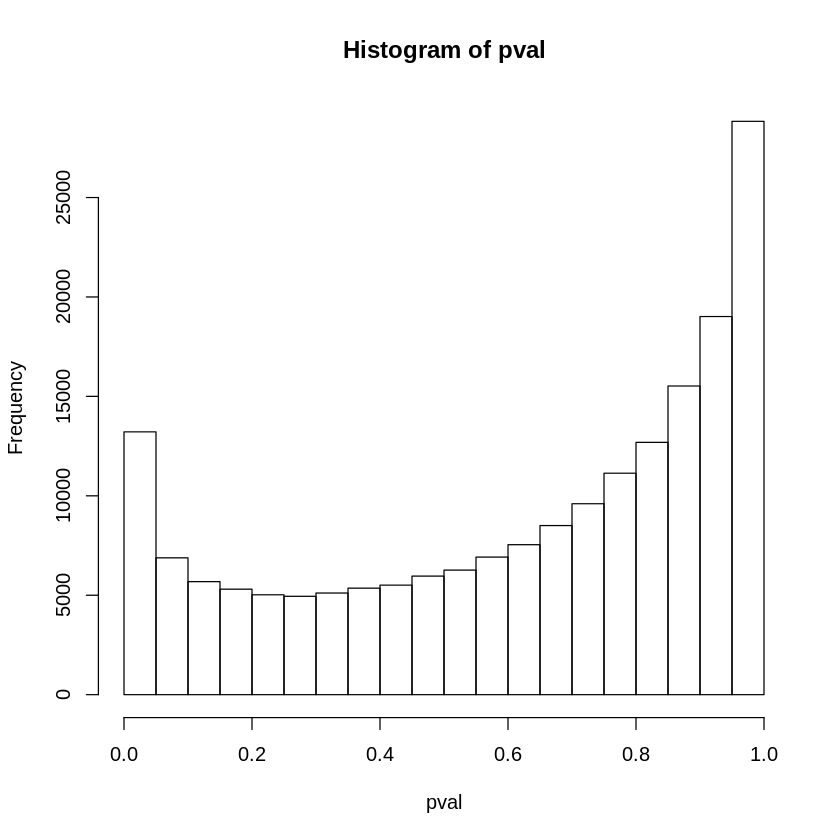

In [16]:
pval <- pchisq(manha_dis_sq, df =10, lower.tail = FALSE)
hist(pval)

In [17]:
is.out <- (pval < (0.05 / length(manha_dis_sq)))  # Bonferroni correction
sum(is.out)

[1] 1799

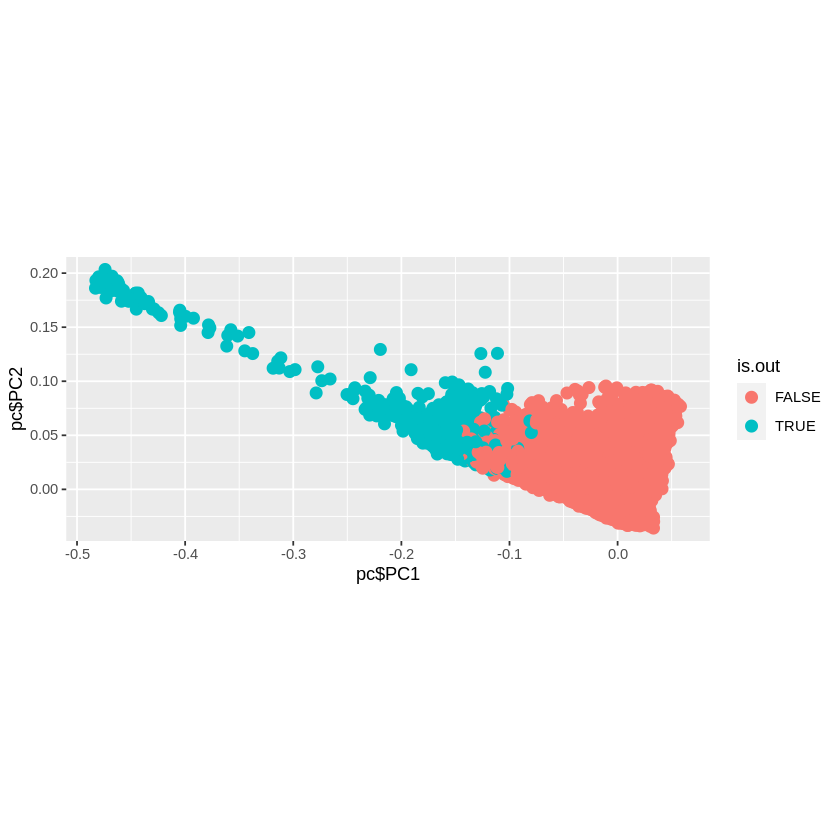

In [18]:
library(ggplot2)
qplot(pc$PC1, pc$PC2, color = is.out, size = I(3)) + coord_equal()

In [12]:
manh_dis_sq_cutoff = quantile(manha_dis_sq,probs = 0.997) #6 sd from the mean chi-square double sided
manh_dis_sq_cutoff

99.7% 
94.11918

In [13]:
max(manha_dis_sq)

[1] 2242.002

In [12]:
#Sample without outliers
new_sample = pc[(manha_dis_sq <= manh_dis_sq_cutoff),1]
length(new_sample)
head(new_sample)

[1] 188448

[1] 1000019 1000035 1000078 1000081 1000198 1000210

In [21]:
#Outlier_codes
outlier = pc[(manha_dis_sq >= manh_dis_sq_cutoff),1]
length(outlier)

[1] 568

In [25]:
# Get the Id for outliers
IID_outlier<-pca %>%
  filter((IID%in%outlier)) %>%
  mutate(FID = IID) %>%
  select(FID, IID)
nrow(IID_outlier)
head(IID_outlier)
write.table(IID_outlier,'ukbb_manhadist_outliers_568ind.txt', sep="\t", row.names=FALSE, col.names=T)

[1] 568

,FID,IID
,<int>,<int>
1,1008606,1008606
2,1010412,1010412
3,1017852,1017852
4,1024366,1024366
5,1035752,1035752
6,1057699,1057699


In [13]:
# removed those NAs and inconsistent cases: 
IID_removed_outlier<-pca %>%
  filter((IID%in%new_sample)) %>%
  mutate(FID = IID) %>%
  select(FID, IID, starts_with("PC"), ethnicity_1)
nrow(IID_removed_outlier)
head(IID_removed_outlier)

[1] 188448

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,ethnicity_1
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1000019,1000019,0.01553941,0.02393847,-0.007491376,-0.005710133,0.008875987,-0.000270289,-0.0002785837,-0.0008964522,0.005746197,-0.001042337,British
2,1000035,1000035,0.01253709,-0.02193925,0.003917083,0.006284067,-0.010311789,0.025505354,-0.0069599583,-0.0101081273,0.003216692,-0.011721235,British
3,1000078,1000078,0.01497620,0.01950002,0.013263954,-0.018580038,0.006379030,-0.001985547,0.0100692105,0.0199936269,-0.004632490,-0.004389401,British
4,1000081,1000081,-0.12213015,0.03863465,0.003532455,-0.002797373,-0.017269542,-0.017946452,-0.0181935503,-0.0108502715,0.015511705,0.006788431,British
5,1000198,1000198,0.01218179,0.02232563,-0.007680613,0.002397714,-0.023268540,0.010575808,-0.0021913240,-0.0026506194,-0.012875036,0.004556960,British
6,1000210,1000210,0.02526840,0.03664394,0.001277694,-0.004001638,-0.003573630,0.015393983,0.0034119557,-0.0023364127,0.016794410,-0.012663409,British


In [14]:
library(ggplot2)
png('ukb23155_s200631.filtered.merged.prune.pc1vpc2.outliers_removed.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC1, y=PC2))+ geom_point(aes(color=ethnicity_1, shape=ethnicity_1), size=2) +
    labs(title="P1 vs PC2 exomes N=188,488",
       x="PC1", y = "PC2") + scale_shape_manual(values=c(0,1,2,3,4,5,8)) +
    theme_classic()
dev.off()

png 
  2

In [17]:
png('ukb23155_s200631.filtered.merged.prune.pc3vpc4.outliers_removed.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC3, y=PC4))+ geom_point(aes(color=ethnicity_1, shape=ethnicity_1), size=2) +
    labs(title="P3 vs PC4 exomes N=188,488",
       x="PC3", y = "PC4") + scale_shape_manual(values=c(0,1,2,3,4,5,8)) +
    theme_classic()
dev.off()

png 
  2

In [18]:
png('ukb23155_s200631.filtered.merged.prune.pc5vpc6.outliers_removed.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC5, y=PC6))+ geom_point(aes(color=ethnicity_1, shape=ethnicity_1), size=2) +
    labs(title="P5 vs PC6 exomes N=188,488",
       x="PC5", y = "PC6") + scale_shape_manual(values=c(0,1,2,3,4,5,8)) +
    theme_classic()
dev.off()

png 
  2

In [112]:
# output sampleIID with outlier removal
write.table(IID_removed_outlier,"exome_IID_188448_outliers_removed.txt",col.names = F,row.names = F,quote = F)

In [81]:
include = (manha_dis_sq <= manh_dis_sq_cutoff)+1
length(include) #528 individuals excluded

[1] 189016

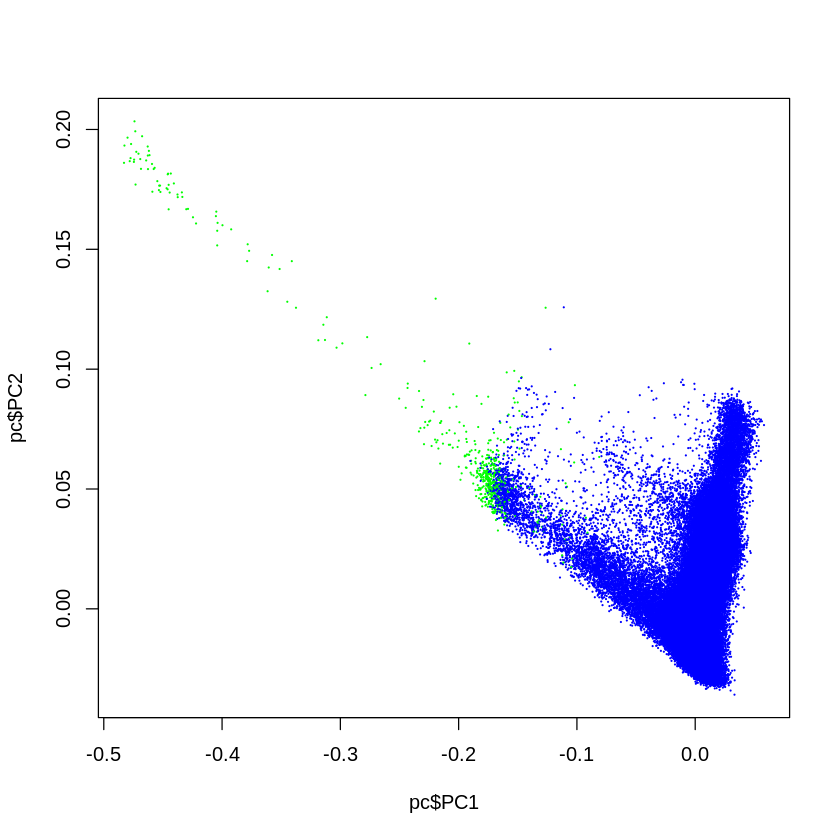

In [107]:
plot(pc$PC1,pc$PC2,col=c("green","blue")[include],cex = .1)

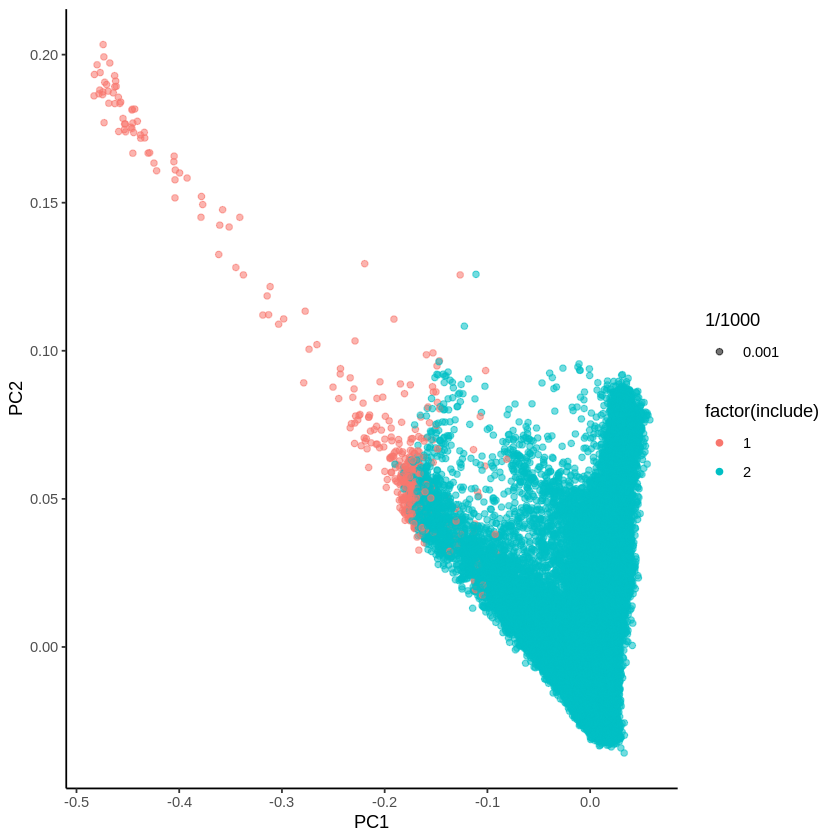

In [105]:
ggplot(pc,aes(x=PC1,PC2)) +  geom_point(aes(color=factor(include),alpha=1/1000)) +
    theme_classic()

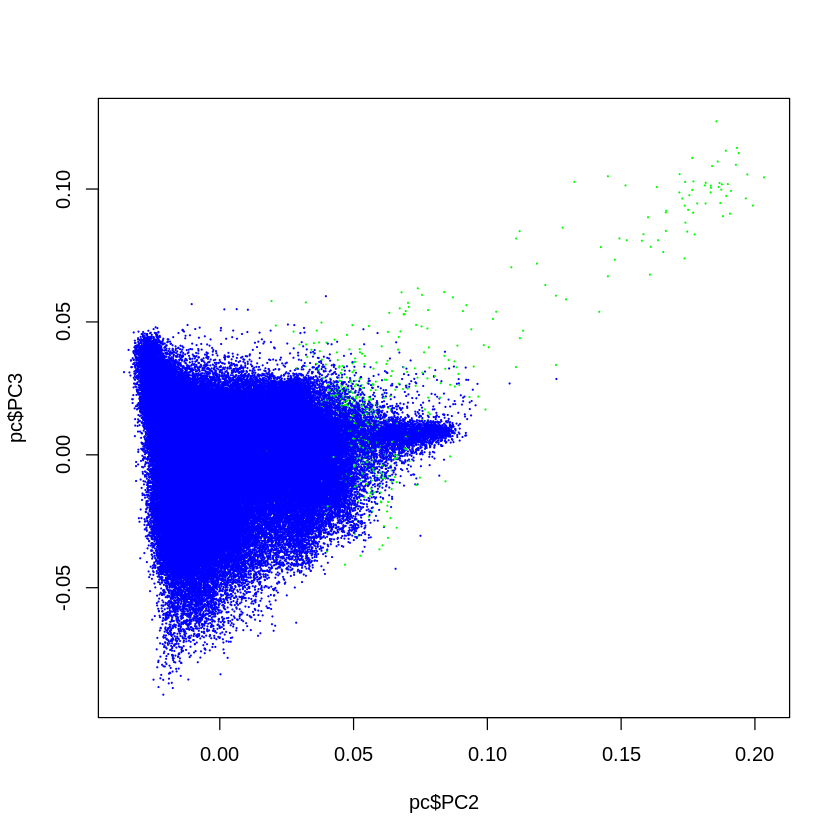

In [108]:
plot(pc$PC2,pc$PC3,col=c("green","blue")[include],cex = .1)

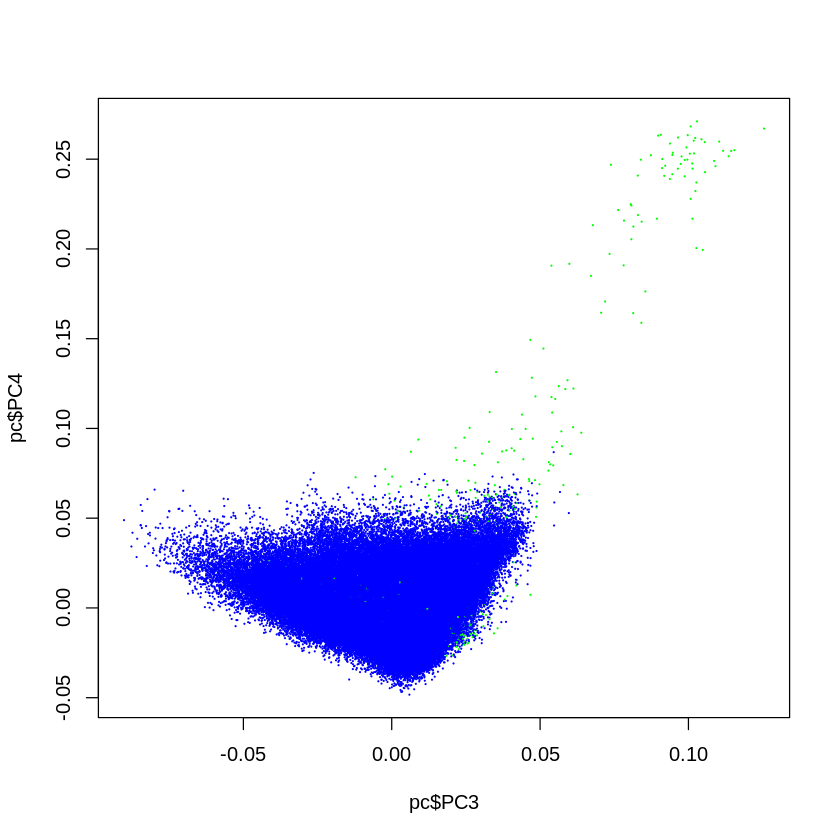

In [109]:
plot(pc$PC3,pc$PC4,col=c("green","blue")[include],cex = .1)

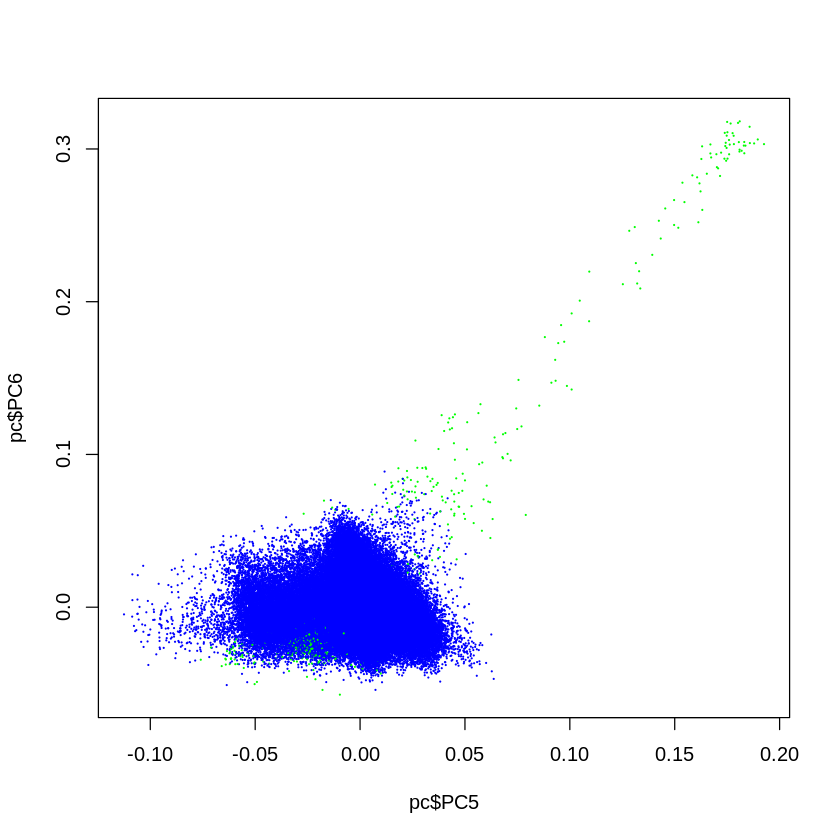

In [110]:
plot(pc$PC5,pc$PC6,col=c("green","blue")[include],cex = .1)

In [29]:
pnorm(3)

[1] 0.9986501

In [27]:
1-pchisq(26.833, 10, lower.tail=FALSE)
pchisq(26.833, 10, lower.tail=FALSE)

[1] 0.9972325

[1] 0.002767512

In [40]:
qchisq(0.997, 10, lower.tail=TRUE)

[1] 26.61079

## Testing PCA for african group

In [1]:
pheno <- read.table("/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/pleiotropy_R01/ukb43978_OCT2020/dc2325_phenotypes/ukb23155_s200631.african_3690ind.pheno", sep="\t")
colnames(pheno) <- c("FID", "IID", "father", "mother","sex", "pheno", "ethnicity", "code", "african_group")
head(pheno)

,FID,IID,father,mother,sex,pheno,ethnicity,code,african_group
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>
1,1000697,1000697,0,0,2,-9,African,4001,Caribbean
2,1001447,1001447,0,0,2,-9,African,4001,Caribbean
3,1002004,1002004,0,0,1,-9,African,4002,African
4,1002354,1002354,0,0,2,-9,African,4001,Caribbean
5,1003139,1003139,0,0,2,-9,African,2001,White and Black Caribbean
6,1004525,1004525,0,0,2,-9,African,4001,Caribbean


In [2]:
pca <- read.table("/home/dc2325/scratch60/pca/african_ancestry/ukb23155_s200631.filtered.merged.prune.pca", sep='\t', header=T)
head(pca)

,IID,FID,father,mother,sex,pheno,ethnicity,ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000697,1000697,0,0,2,-9,African,1000697:1000697,-0.04091368,0.007203415,0.0009930804,-0.036272094,-0.003041363,-0.0192737842,-0.006621332,-0.004094591,-0.004256426,4.172388e-02
2,1001447,1001447,0,0,2,-9,African,1001447:1001447,0.06168854,0.008397967,-0.0011191831,-0.002114511,0.002161833,-0.0008537678,-0.002200975,-0.046038608,0.016120939,5.350694e-02
3,1002004,1002004,0,0,1,-9,African,1002004:1002004,0.10568097,0.017719131,0.0452651667,-0.020333547,0.056083806,0.0033348241,0.006903723,-0.011871961,-0.002934855,-1.082279e-02
4,1002354,1002354,0,0,2,-9,African,1002354:1002354,-0.02366523,0.010337650,-0.0067607072,-0.001500778,-0.008177976,-0.0052212384,0.029593527,0.042973230,-0.010367158,1.374882e-02
5,1003139,1003139,0,0,2,-9,African,1003139:1003139,-0.26071476,0.040471204,-0.0149074250,0.022049041,-0.003672586,0.0022960518,0.007009858,0.012798464,0.010561072,-5.353898e-05
6,1004525,1004525,0,0,2,-9,African,1004525:1004525,0.10185339,0.005029643,-0.0040971428,-0.008380001,-0.001647817,0.0119478937,-0.015280542,0.002952862,-0.011976892,-6.295445e-03


In [3]:
pca_final <-merge(pca, pheno, by=c("FID","IID","father", "mother", "pheno", "sex", "ethnicity"), all.x=TRUE, all.y=FALSE)
head(pca_final)

,FID,IID,father,mother,pheno,sex,ethnicity,ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,code,african_group
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1,1000697,1000697,0,0,-9,2,African,1000697:1000697,-0.04091368,0.007203415,0.0009930804,-0.036272094,-0.003041363,-0.0192737842,-0.006621332,-0.004094591,-0.004256426,4.172388e-02,4001,Caribbean
2,1001447,1001447,0,0,-9,2,African,1001447:1001447,0.06168854,0.008397967,-0.0011191831,-0.002114511,0.002161833,-0.0008537678,-0.002200975,-0.046038608,0.016120939,5.350694e-02,4001,Caribbean
3,1002004,1002004,0,0,-9,1,African,1002004:1002004,0.10568097,0.017719131,0.0452651667,-0.020333547,0.056083806,0.0033348241,0.006903723,-0.011871961,-0.002934855,-1.082279e-02,4002,African
4,1002354,1002354,0,0,-9,2,African,1002354:1002354,-0.02366523,0.010337650,-0.0067607072,-0.001500778,-0.008177976,-0.0052212384,0.029593527,0.042973230,-0.010367158,1.374882e-02,4001,Caribbean
5,1003139,1003139,0,0,-9,2,African,1003139:1003139,-0.26071476,0.040471204,-0.0149074250,0.022049041,-0.003672586,0.0022960518,0.007009858,0.012798464,0.010561072,-5.353898e-05,2001,White and Black Caribbean
6,1004525,1004525,0,0,-9,2,African,1004525:1004525,0.10185339,0.005029643,-0.0040971428,-0.008380001,-0.001647817,0.0119478937,-0.015280542,0.002952862,-0.011976892,-6.295445e-03,4001,Caribbean


## Plots without oulier removal

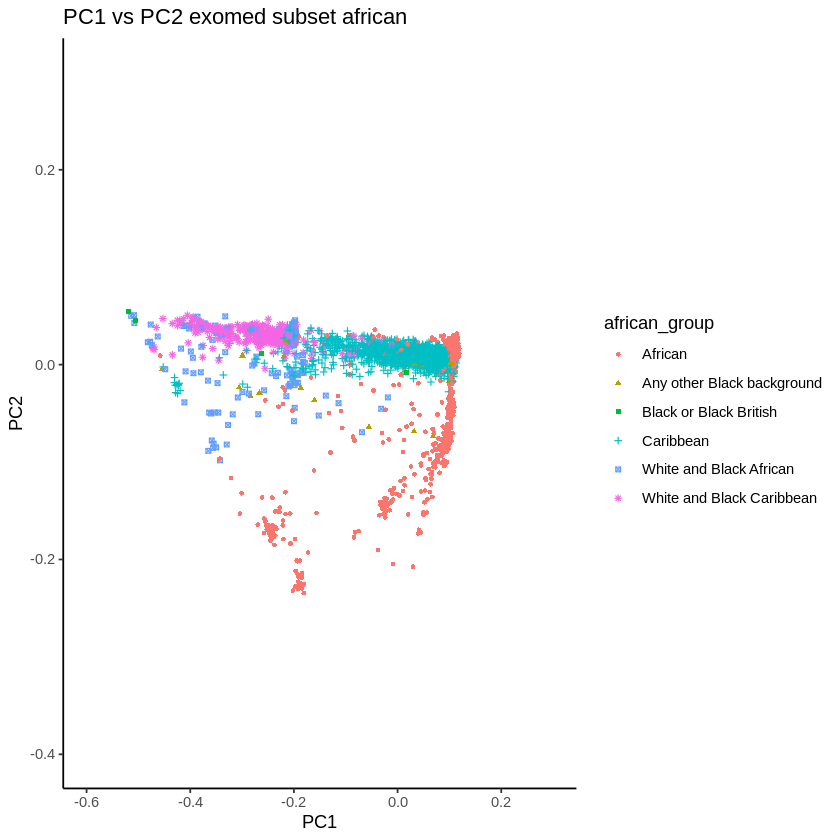

In [150]:
library(ggplot2)
#png('/home/dc2325/scratch60/pca/african_ancestry/ukb23155_s200631.filtered.merged.prune.pc1vpc2.groups.png', width = 6, height = 4, unit='in', res=300)
ggplot(pca_final, aes(x=PC1, y=PC2)) + geom_point(aes(color=african_group, shape=african_group), size=1)  + labs(title="PC1 vs PC2 exomed subset african",x="PC1", y="PC2") + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.6, 0.3)) + theme_classic()
#dev.off()

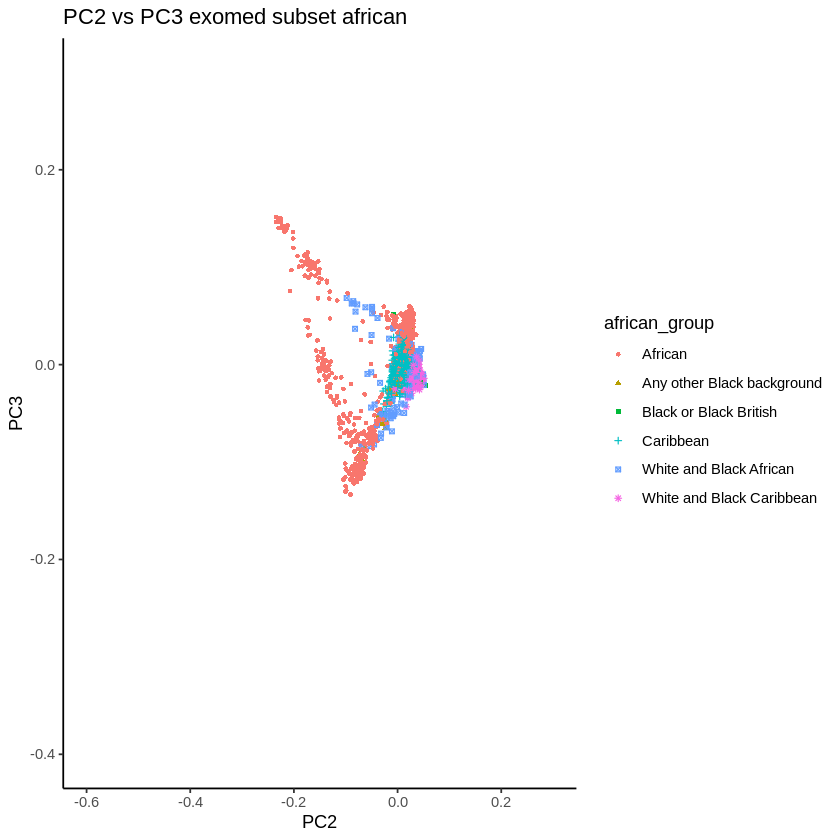

In [151]:
#png('/home/dc2325/scratch60/pca/african_ancestry/ukb23155_s200631.filtered.merged.prune.pc2vpc3.groups.png', width = 6, height = 4, unit='in', res=300)
ggplot(pca_final, aes(x=PC2, y=PC3)) + geom_point(aes(color=african_group, shape=african_group), size=1) + labs(title="PC2 vs PC3 exomed subset african", x="PC2", y="PC3") + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.6, 0.3)) + theme_classic()
#dev.off()

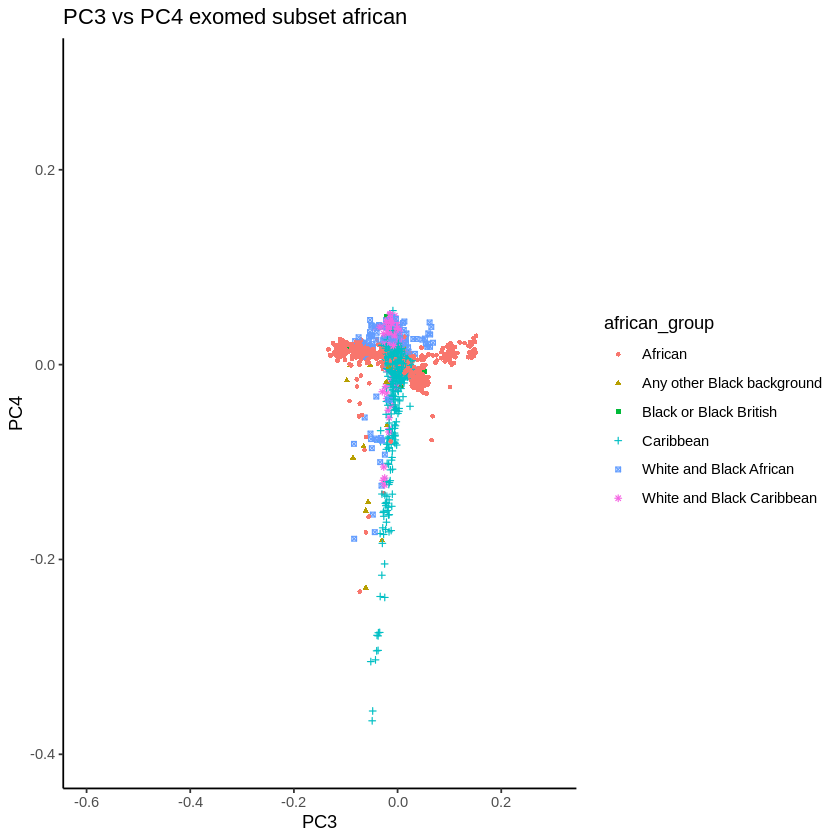

In [152]:
#png('/home/dc2325/scratch60/pca/african_ancestry/ukb23155_s200631.filtered.merged.prune.pc3vpc4.groups.png', width = 6, height = 4, unit='in', res=300)
ggplot(pca_final,aes(x=PC3, y=PC4)) + geom_point(aes(color=african_group, shape=african_group), size=1) + labs(title="PC3 vs PC4 exomed subset african", x="PC3", y="PC4") + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.6, 0.3)) + theme_classic()
#dev.off()

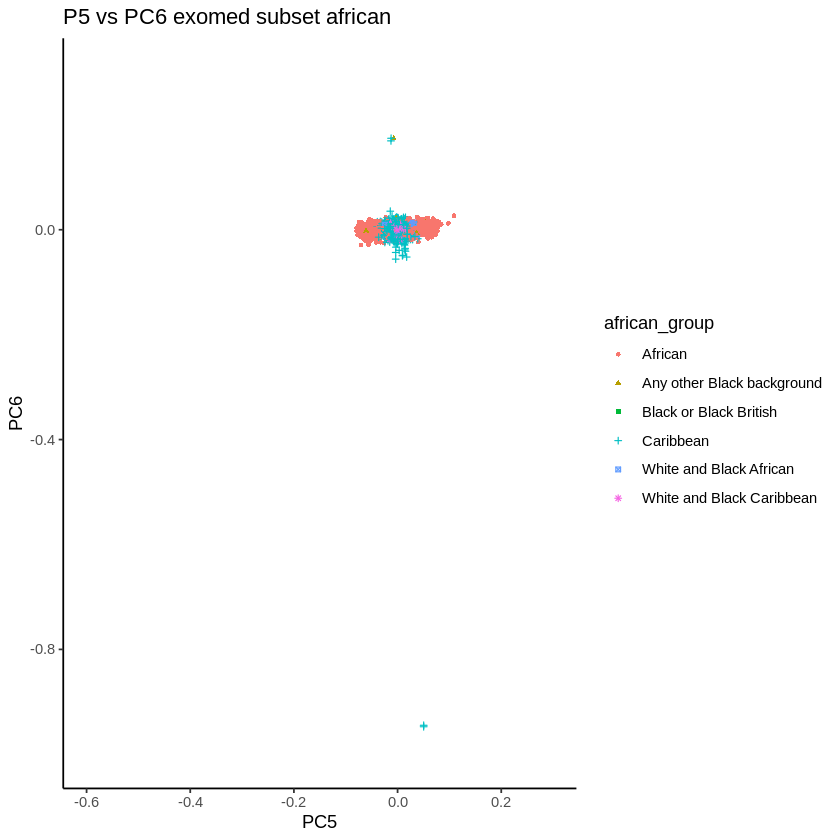

In [153]:
#png('/home/dc2325/scratch60/pca/african_ancestry/ukb23155_s200631.filtered.merged.prune.pc5vpc6.groups.png', width = 6, height = 4, unit='in', res=300)
ggplot(pca_final, aes(x=PC5, y=PC6)) + geom_point(aes(color=african_group, shape=african_group), size=1) + labs(title="P5 vs PC6 exomed subset african",x="PC5", y="PC6") + scale_y_continuous(limits=c(-1, 0.3))  + scale_x_continuous(limits=c(-0.6, 0.3))+theme_classic()
#dev.off() 

## Calculate manhalanobis for African group

In [4]:
library(dplyr)
pc = pca_final %>%
    select("IID", "african_group", starts_with("PC"),)
head(pc)
nrow(pc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,IID,african_group,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000697,Caribbean,-0.04091368,0.007203415,0.0009930804,-0.036272094,-0.003041363,-0.0192737842,-0.006621332,-0.004094591,-0.004256426,4.172388e-02
2,1001447,Caribbean,0.06168854,0.008397967,-0.0011191831,-0.002114511,0.002161833,-0.0008537678,-0.002200975,-0.046038608,0.016120939,5.350694e-02
3,1002004,African,0.10568097,0.017719131,0.0452651667,-0.020333547,0.056083806,0.0033348241,0.006903723,-0.011871961,-0.002934855,-1.082279e-02
4,1002354,Caribbean,-0.02366523,0.010337650,-0.0067607072,-0.001500778,-0.008177976,-0.0052212384,0.029593527,0.042973230,-0.010367158,1.374882e-02
5,1003139,White and Black Caribbean,-0.26071476,0.040471204,-0.0149074250,0.022049041,-0.003672586,0.0022960518,0.007009858,0.012798464,0.010561072,-5.353898e-05
6,1004525,Caribbean,0.10185339,0.005029643,-0.0040971428,-0.008380001,-0.001647817,0.0119478937,-0.015280542,0.002952862,-0.011976892,-6.295445e-03


[1] 3690

In [5]:
# calculate covariance of the features
PC_cov = cov(pc[,3:12])
head(PC_cov)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,1.823532e-02,1.940821e-19,2.320394e-19,-1.526568e-19,-1.680455e-19,1.289080e-19,-1.639901e-19,1.966767e-19,-2.055395e-19,1.541266e-19
PC2,1.940821e-19,1.662959e-03,2.170370e-19,-7.330084e-20,3.038694e-21,-2.589568e-21,2.468484e-20,-5.726631e-20,4.391684e-20,-7.889071e-21
PC3,2.320394e-19,2.170370e-19,1.088216e-03,1.291441e-19,-9.595081e-20,-3.405308e-20,6.060029e-20,-2.402139e-20,3.298318e-23,2.428516e-21
PC4,-1.526568e-19,-7.330084e-20,1.291441e-19,8.996582e-04,-4.263522e-19,-1.227903e-19,4.931568e-20,-1.783791e-19,3.902596e-20,-7.975987e-20
PC5,-1.680455e-19,3.038694e-21,-9.595081e-20,-4.263522e-19,7.370726e-04,4.933682e-21,-9.753209e-20,2.300166e-19,-1.384714e-19,3.783374e-20
PC6,1.289080e-19,-2.589568e-21,-3.405308e-20,-1.227903e-19,4.933682e-21,5.776872e-04,-8.968002e-20,1.200593e-19,-7.700387e-20,9.559081e-21


In [6]:
# Find the inverse of the covariance matrix
inv_PC_cov = solve(PC_cov)
head(inv_PC_cov )

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,5.483864e+01,-6.400155e-15,-1.169320e-14,9.305194e-15,1.250268e-14,-1.223697e-14,1.614916e-14,-2.006478e-14,2.130586e-14,-1.634961e-14
PC2,-6.400155e-15,6.013376e+02,-1.199325e-13,4.899477e-14,-2.479106e-15,2.695585e-15,-2.665596e-14,6.406373e-14,-4.991909e-14,9.176715e-15
PC3,-1.169320e-14,-1.199325e-13,9.189353e+02,-1.319113e-13,1.196254e-13,5.416873e-14,-1.000012e-13,4.106557e-14,-5.729210e-17,-4.316870e-15
PC4,9.305194e-15,4.899477e-14,-1.319113e-13,1.111533e+03,6.429552e-13,2.362620e-13,-9.843582e-14,3.688596e-13,-8.199612e-14,1.714944e-13
PC5,1.250268e-14,-2.479106e-15,1.196254e-13,6.429552e-13,1.356718e+03,-1.158692e-14,2.376200e-13,-5.805553e-13,3.551134e-13,-9.929150e-14
PC6,-1.223697e-14,2.695585e-15,5.416873e-14,2.362620e-13,-1.158692e-14,1.731041e+03,2.787717e-13,-3.866321e-13,2.519632e-13,-3.200859e-14


In [7]:
# Calculate the mean for each variable
PC_mean=apply(pc[,3:12], 2, mean)
head(PC_mean)

PC1           PC2           PC3           PC4           PC5 
 4.206433e-17 -1.892475e-16  6.808271e-17 -1.933783e-17  5.097181e-17 
          PC6 
-4.422229e-17

In [8]:
manha_dis_sq = apply(pc[,3:12], 1, FUN=function(x){t(x-PC_mean)%*% inv_PC_cov %*% (x-PC_mean)})
manha_dis_sq

[1]    5.7536192   10.2460238    8.0209840    5.8544091    6.0882708
   [6]    1.7117208    8.4655297    6.8288128    2.5134096    2.4121603
  [11]    1.4831406    1.5081013   49.5042609   19.2070266    3.9280009
  [16]    1.7563514   12.8992390    1.3682911    7.2189426    5.0464761
  [21]    0.8238409    2.3282630   15.6625953    1.2812681    3.7248847
  [26]    1.4963199    5.0088399    4.7727962    4.4494590   12.6582359
  [31]    5.8034111    8.5234915    7.0749373    3.0458497    5.5628264
  [36]    1.3263300    4.3227015    1.6658607    4.2287473    5.2739678
  [41]    6.1782060   13.9682058    5.5873427    5.6257087    0.8795701
  [46]    0.8869719    7.8488597    4.3242139    0.5879097    2.2989997
  [51]    3.5636175    2.3752192    2.3858608    3.5675609    6.9514526
  [56]    5.4069108    8.0973537    7.0774057   12.4416910   10.3697780
  [61]    2.6735826   19.9851682    1.7309030    7.5405343    2.7405749
  [66]    7.6991912    1.4076405    3.3882946    4.1100894    8.0526918
  [71]    2.3299474    4.7656565    1.4952947    8.0680276    1.8641544
  [76]    5.3011374    2.1349662    4.0529200    5.7963586    5.5842798
  [81]    7.0261079    1.1955043    1.5955942    0.6729821    1.5434363
  [86]    2.5849133    4.1246186    0.8477550   19.0166414    4.1199748
  [91]   25.4120254    4.8332435    5.0965913    9.6492221    0.7738481
  [96]    1.7186573    7.2183953    8.5104040    5.3118139    7.5291011
 [101]   12.3780062    1.6145955    6.0647950    1.4473212    5.8552184
 [106]    2.4703232    1.6821356    8.8315384    8.5980708    1.1174590
 [111]    7.9775780   19.6693844    2.3800623   11.4127291    1.8028822
 [116]    1.6916985    1.4136422    2.5980059    9.4683868   29.8288143
 [121]    8.0308272    3.9279187   15.2686358    2.6803110    4.1574968
 [126]   19.3776749    1.7722312   14.2505577    9.0329592    2.1666989
 [131]   20.8651578    2.3313300    2.9241200    9.0685094    5.1554224
 [136]    1.7316121    4.0256985    1.2504959    5.8235282   15.4178323
 [141]    7.1203349    2.2048816    3.0384653   12.6139204   32.1829518
 [146]    0.9379607    1.4646733    1.4598874    7.9021750    7.0996606
 [151]    5.6573176   15.9741024    2.7426276    1.8030561    3.2345590
 [156]   24.9024576    5.9572966    4.3238668   13.4058466   15.1627824
 [161]    2.5241959   17.2572527    3.8627816    4.7745414   35.7407752
 [166]    6.6245912   15.8633464   17.9435044    7.2065690    2.8351080
 [171]    9.6841499    6.2198936    3.5518496    2.7425285    7.6827989
 [176]    1.7203649    4.2332391    5.0046243    2.1623681   15.4295849
 [181]    7.2159632    2.2319146    6.2114454    1.1289164    4.9256441
 [186]    9.7515347    0.9585354    1.9724549    1.7256678    4.2890184
 [191]   11.4040266    4.2731656    3.1675604    1.6615630    4.5472632
 [196]    3.9886649    7.2776371    5.9070750    3.9310866    6.3165655
 [201]    8.5789831    3.6007569   15.6606575    8.9115367    7.1072332
 [206]    3.7357780    5.8159361    1.3311075    2.6237017    3.8338548
 [211]    6.1595577    7.4776139    4.3871933    9.7395191    2.7722107
 [216]    6.7158772    9.9409814    2.4601387   17.7304592    7.2231436
 [221]    6.4351764   12.3018560    0.9518114    3.3134767   12.3335411
 [226]    0.9595893    3.2212916    1.6581763   17.0831403   10.6386342
 [231]    7.5819310    1.8577912    3.7111238    1.8378900    2.0968672
 [236]    2.0027643   11.7945047    4.3484600   14.6075114    7.9053638
 [241]    8.2141956    3.7308202   50.2491223    4.0827999    1.9840367
 [246]    1.2721235    4.4544608   45.1713995    7.7499263    6.6957915
 [251]    8.0435714    4.3322660    5.0633329    3.8382673    3.9555075
 [256]    3.5304604    4.6668959   13.1051729    1.8512927    2.1293978
 [261]    2.5599033    2.6162968    1.3237038   13.1529786   12.6819189
 [266]    4.7271204    9.7772062    3.6663048    3.1638439    1.4807676
 [271]    2.3154938    9.3106721    1.8474314   10.5973735    8.4606174
 [276]    2.2347823    5.1485658    2.34603

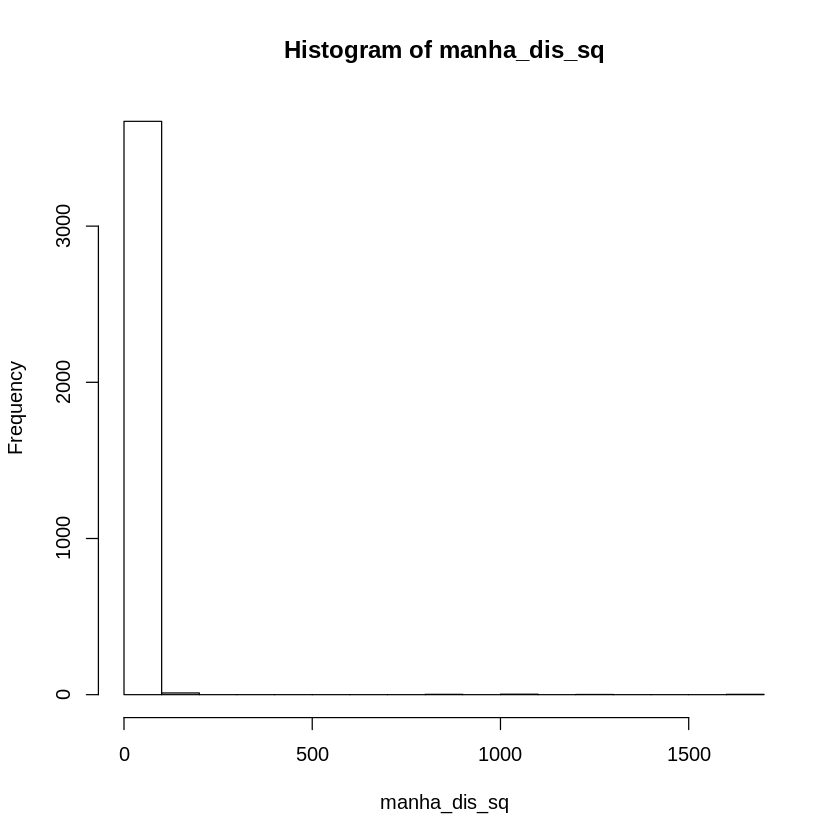

In [9]:
hist(manha_dis_sq)

In [10]:
manh_dis_sq_cutoff = quantile(manha_dis_sq,probs = 0.95) #6 sd from the mean chi-square double sided
manh_dis_sq_cutoff

95% 
23.30759

In [11]:
sd(manha_dis_sq)

[1] 56.87876

In [16]:
out= capture.output(summary(manha_dis_sq))

In [17]:
out

[1] "     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. "
[2] "   0.2456    2.1965    4.4673    9.9973    8.3159 1646.3661 "

In [18]:
write.table(out,'~/project/UKBB_GWAS_dev/test.txt', sep="\n",append=TRUE)

Warning message in write.table(out, "~/project/UKBB_GWAS_dev/test.txt", sep = "\n", :
“appending column names to file”


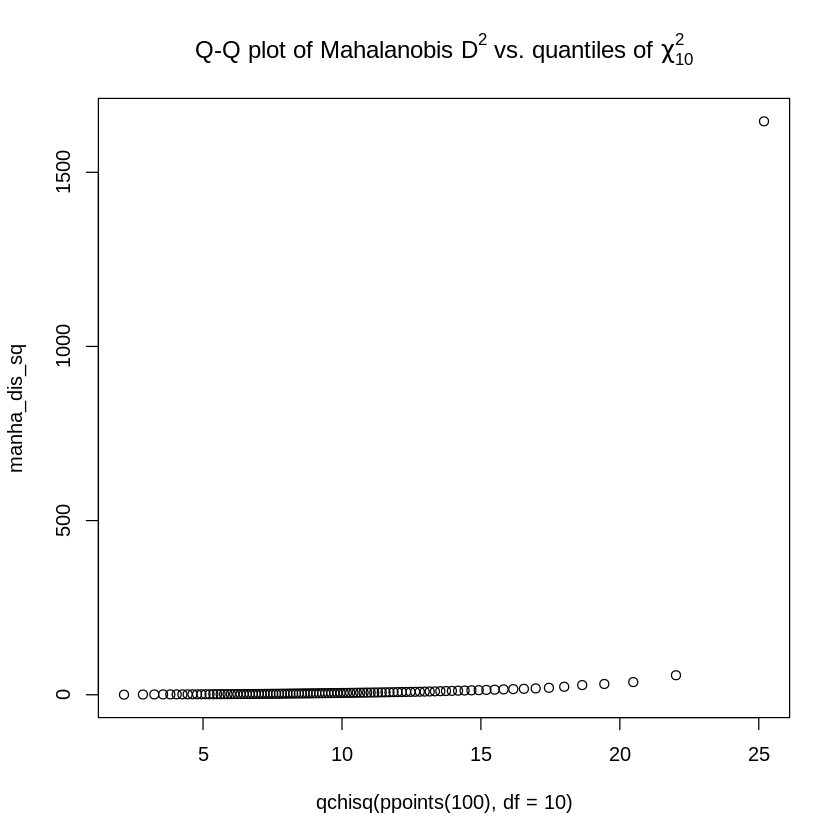

In [48]:
qqplot(qchisq(ppoints(100), df=10), manha_dis_sq, main = expression("Q-Q plot of Mahalanobis" * ~D^2 * " vs. quantiles of" * ~ chi[10]^2))

In [49]:
length(which(manha_dis_sq >= manh_dis_sq_cutoff))

[1] 185

In [50]:
#Sample without outliers
new_sample = pc[(manha_dis_sq <= manh_dis_sq_cutoff),1]
length(new_sample)
head(new_sample)

[1] 3505

[1] 1000697 1001447 1002004 1002354 1003139 1004525

In [51]:
#Outlier_codes
outlier = pc[(manha_dis_sq >= manh_dis_sq_cutoff),1]
length(outlier)

[1] 185

In [53]:
# removed those NAs and inconsistent cases: 
IID_removed_outlier<-pca_final %>%
  filter((IID%in%new_sample)) %>%
  mutate(FID = IID) %>%
  select(FID, IID, starts_with("PC"), african_group)
nrow(IID_removed_outlier)
head(IID_removed_outlier)

[1] 3505

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,african_group
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1000697,1000697,-0.04091368,0.007203415,0.0009930804,-0.036272094,-0.003041363,-0.0192737842,-0.006621332,-0.004094591,-0.004256426,4.172388e-02,Caribbean
2,1001447,1001447,0.06168854,0.008397967,-0.0011191831,-0.002114511,0.002161833,-0.0008537678,-0.002200975,-0.046038608,0.016120939,5.350694e-02,Caribbean
3,1002004,1002004,0.10568097,0.017719131,0.0452651667,-0.020333547,0.056083806,0.0033348241,0.006903723,-0.011871961,-0.002934855,-1.082279e-02,African
4,1002354,1002354,-0.02366523,0.010337650,-0.0067607072,-0.001500778,-0.008177976,-0.0052212384,0.029593527,0.042973230,-0.010367158,1.374882e-02,Caribbean
5,1003139,1003139,-0.26071476,0.040471204,-0.0149074250,0.022049041,-0.003672586,0.0022960518,0.007009858,0.012798464,0.010561072,-5.353898e-05,White and Black Caribbean
6,1004525,1004525,0.10185339,0.005029643,-0.0040971428,-0.008380001,-0.001647817,0.0119478937,-0.015280542,0.002952862,-0.011976892,-6.295445e-03,Caribbean


## Plots with outlier removal

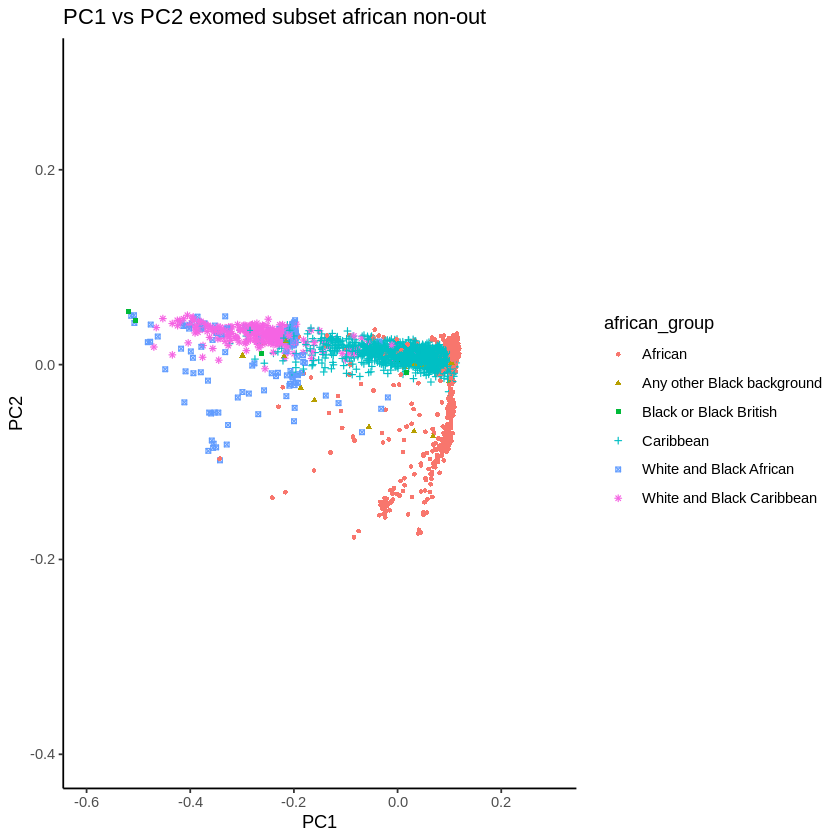

In [168]:
#png('/home/dc2325/scratch60/pca/african_ancestry/ukb23155_s200631.filtered.merged.prune.pc1vpc2.groups_outrm.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC1, y=PC2)) + geom_point(aes(color=african_group, shape=african_group), size=1) + labs(title="PC1 vs PC2 exomed subset african non-out",x="PC1", y="PC2")  + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.6, 0.3)) + theme_classic()
#dev.off()

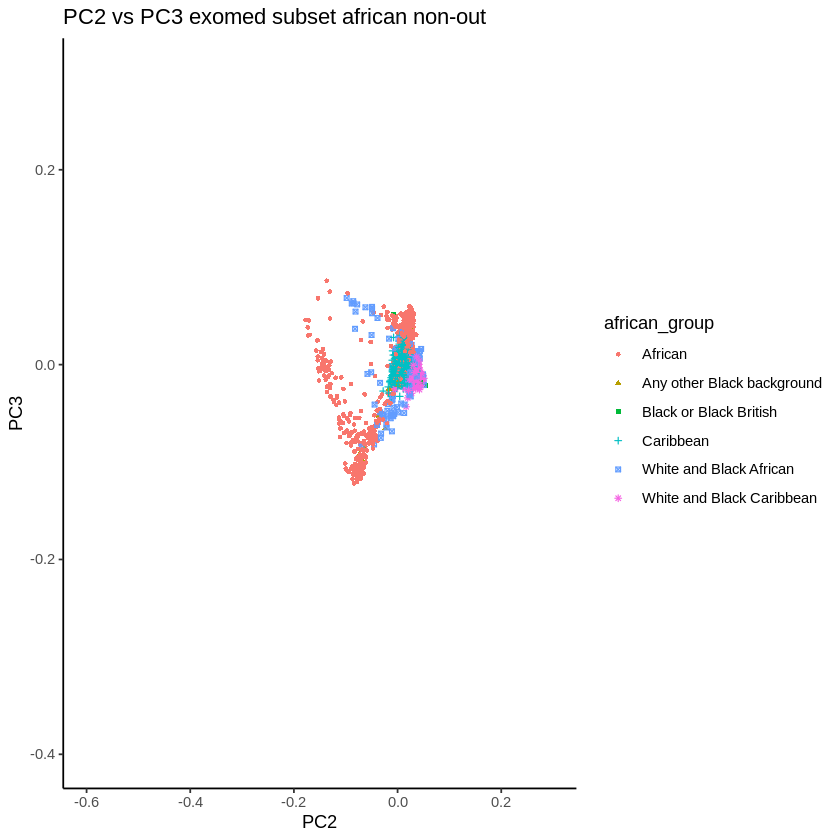

In [169]:
#png('/home/dc2325/scratch60/pca/african_ancestry/ukb23155_s200631.filtered.merged.prune.pc2vpc3.groups_outrm.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC2, y=PC3)) + geom_point(aes(color=african_group, shape=african_group), size=1) + labs(title="PC2 vs PC3 exomed subset african non-out", x="PC2", y="PC3")  + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.6, 0.3)) + theme_classic()
#dev.off()

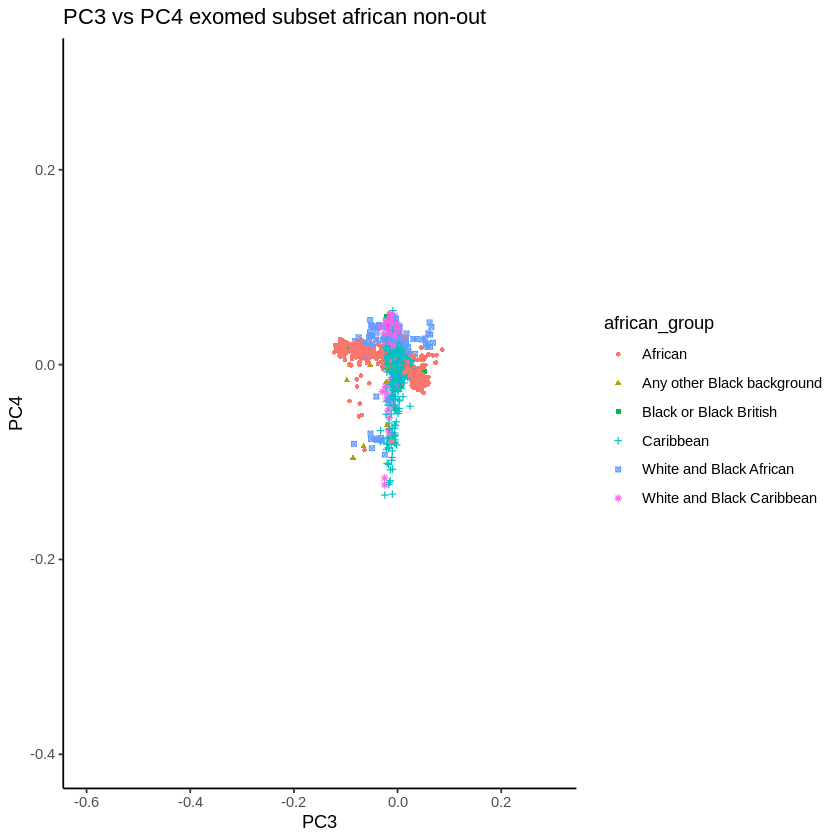

In [172]:
#png('/home/dc2325/scratch60/pca/african_ancestry/ukb23155_s200631.filtered.merged.prune.pc3vpc4.groups_outrm.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC3, y=PC4)) + geom_point(aes(color=african_group, shape=african_group), size=1) + labs(title="PC3 vs PC4 exomed subset african non-out", x="PC3", y="PC4")  + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.6, 0.3)) + theme_classic()
#dev.off()

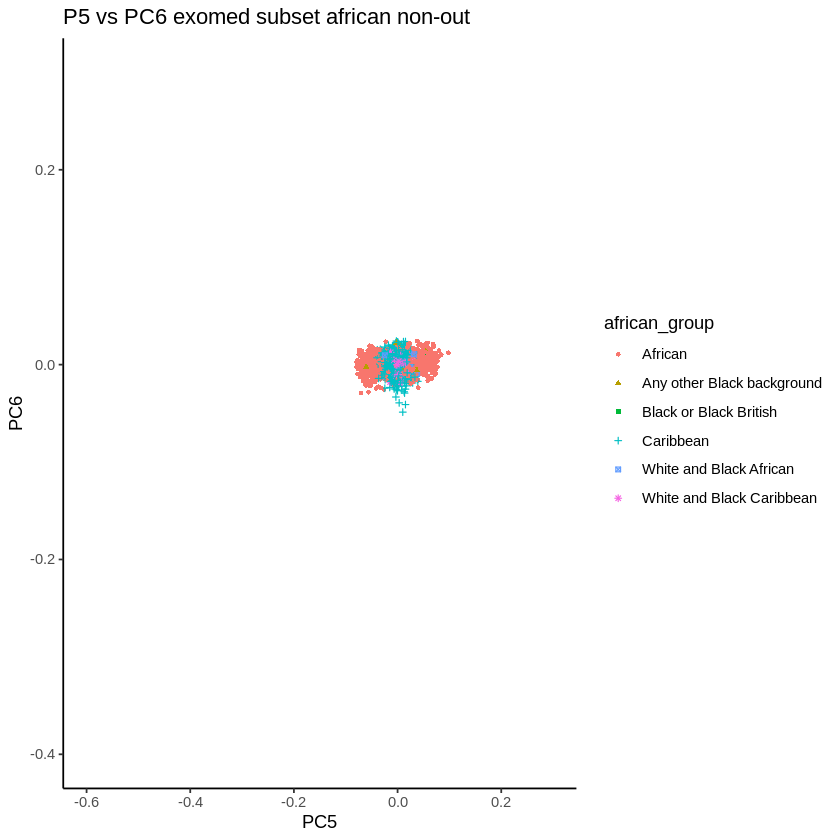

In [173]:
#png('/home/dc2325/scratch60/pca/african_ancestry/ukb23155_s200631.filtered.merged.prune.pc5vpc6.groups_outrm.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier, aes(x=PC5, y=PC6)) + geom_point(aes(color=african_group, shape=african_group), size=1) + labs(title="P5 vs PC6 exomed subset african non-out",x="PC5", y="PC6")  + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.6, 0.3)) + theme_classic()
#dev.off() 

## Testing PCA asian group

In [63]:
pheno_2 <- read.table("/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/pleiotropy_R01/ukb43978_OCT2020/dc2325_phenotypes/ukb23155_s200631.asian_4618ind.pheno", sep="\t")
colnames(pheno_2) <- c("FID", "IID", "father", "mother","sex", "pheno", "ethnicity", "code", "asian_group")
head(pheno_2)

,FID,IID,father,mother,sex,pheno,ethnicity,code,asian_group
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>
1,1003025,1003025,0,0,1,-9,Asian,3001,Indian
2,1003083,1003083,0,0,1,-9,Asian,3001,Indian
3,1004223,1004223,0,0,1,-9,Asian,3002,Pakistani
4,1005191,1005191,0,0,2,-9,Asian,3001,Indian
5,1005270,1005270,0,0,2,-9,Asian,3004,Any other Asian background
6,1005298,1005298,0,0,2,-9,Asian,3001,Indian


In [64]:
pca_2 <- read.table("/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.pca", sep='\t', header=T)
head(pca_2)

,IID,FID,father,mother,sex,pheno,ethnicity,ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1003025,1003025,0,0,1,-9,Asian,1003025:1003025,-0.045078438,-0.02351121,-0.03727598,-0.001939958,0.017237348,0.0079387695,0.008515296,-0.012932158,0.046694673,-0.011798214
2,1003083,1003083,0,0,1,-9,Asian,1003083:1003083,0.003444015,0.10163381,0.02795629,-0.139833394,0.012967797,0.0056468977,-0.001013907,0.001144330,-0.003324610,-0.021462816
3,1004223,1004223,0,0,1,-9,Asian,1004223:1004223,-0.034232497,-0.01500652,-0.04103763,0.007570796,0.006976456,0.0002015189,0.011007363,0.001573166,0.015790846,-0.011300011
4,1005191,1005191,0,0,2,-9,Asian,1005191:1005191,-0.037983866,-0.02395562,-0.01539751,-0.004815979,-0.008516932,-0.0151500229,-0.014679563,0.004927707,-0.001150084,-0.005391575
5,1005270,1005270,0,0,2,-9,Asian,1005270:1005270,0.021944835,0.09187301,0.03076726,0.027373091,0.021310332,-0.0078462732,0.002226294,-0.011685237,0.004011084,-0.011672098
6,1005298,1005298,0,0,2,-9,Asian,1005298:1005298,-0.027328636,-0.01706592,-0.03566045,0.004565163,0.003189469,-0.0045964083,-0.012593044,-0.013760497,-0.025179204,-0.052337910


In [65]:
pca_final_2 <-merge(pca_2, pheno_2, by=c("FID","IID","father", "mother", "pheno", "sex", "ethnicity"), all.x=TRUE, all.y=FALSE)
head(pca_final_2)

,FID,IID,father,mother,pheno,sex,ethnicity,ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,code,asian_group
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1,1003025,1003025,0,0,-9,1,Asian,1003025:1003025,-0.045078438,-0.02351121,-0.03727598,-0.001939958,0.017237348,0.0079387695,0.008515296,-0.012932158,0.046694673,-0.011798214,3001,Indian
2,1003083,1003083,0,0,-9,1,Asian,1003083:1003083,0.003444015,0.10163381,0.02795629,-0.139833394,0.012967797,0.0056468977,-0.001013907,0.001144330,-0.003324610,-0.021462816,3001,Indian
3,1004223,1004223,0,0,-9,1,Asian,1004223:1004223,-0.034232497,-0.01500652,-0.04103763,0.007570796,0.006976456,0.0002015189,0.011007363,0.001573166,0.015790846,-0.011300011,3002,Pakistani
4,1005191,1005191,0,0,-9,2,Asian,1005191:1005191,-0.037983866,-0.02395562,-0.01539751,-0.004815979,-0.008516932,-0.0151500229,-0.014679563,0.004927707,-0.001150084,-0.005391575,3001,Indian
5,1005270,1005270,0,0,-9,2,Asian,1005270:1005270,0.021944835,0.09187301,0.03076726,0.027373091,0.021310332,-0.0078462732,0.002226294,-0.011685237,0.004011084,-0.011672098,3004,Any other Asian background
6,1005298,1005298,0,0,-9,2,Asian,1005298:1005298,-0.027328636,-0.01706592,-0.03566045,0.004565163,0.003189469,-0.0045964083,-0.012593044,-0.013760497,-0.025179204,-0.052337910,3001,Indian


## Plots without outlier removal

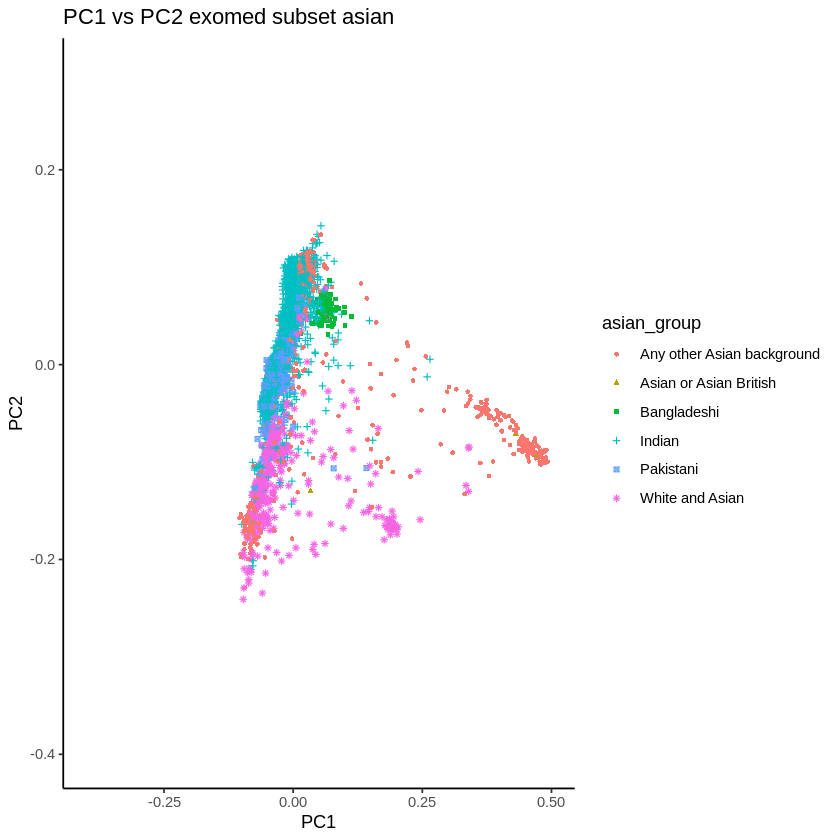

In [158]:
#library(ggplot2)
#png('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.pc1vpc2.groups.png', width = 6, height = 4, unit='in', res=300)
ggplot(pca_final_2, aes(x=PC1, y=PC2)) + geom_point(aes(color=asian_group, shape=asian_group), size=1) + labs(title="PC1 vs PC2 exomed subset asian",x="PC1", y="PC2") + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.4, 0.5)) + theme_classic()
#dev.off()

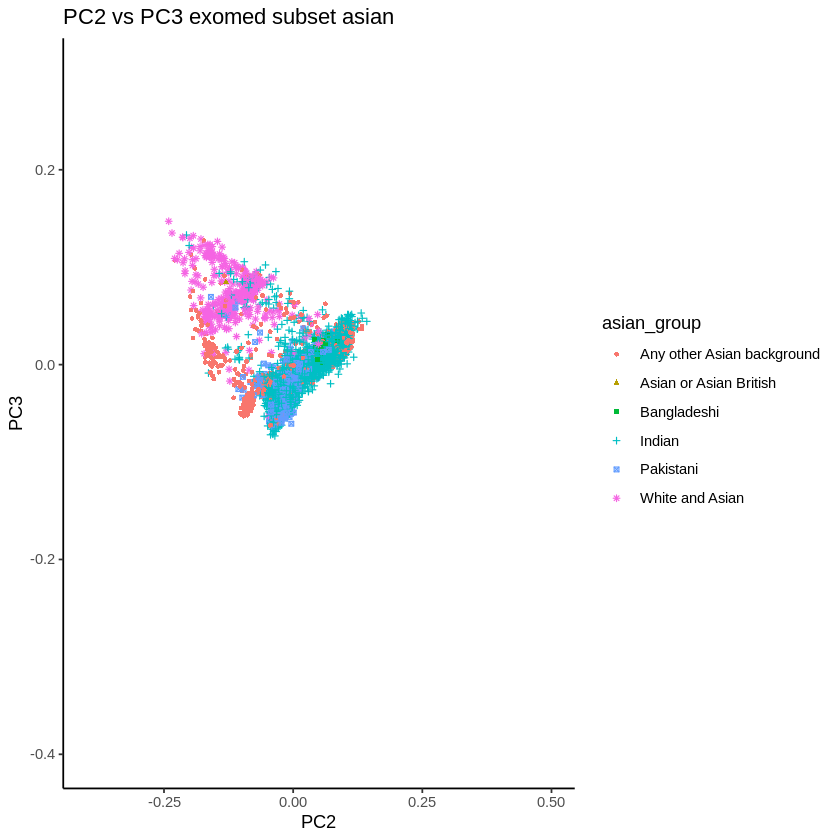

In [159]:
#png('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.pc2vpc3.groups.png', width = 6, height = 4, unit='in', res=300)
ggplot(pca_final_2, aes(x=PC2, y=PC3)) + geom_point(aes(color=asian_group, shape=asian_group), size=1) + labs(title="PC2 vs PC3 exomed subset asian", x="PC2", y="PC3") + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.4, 0.5))+ theme_classic()
#dev.off()

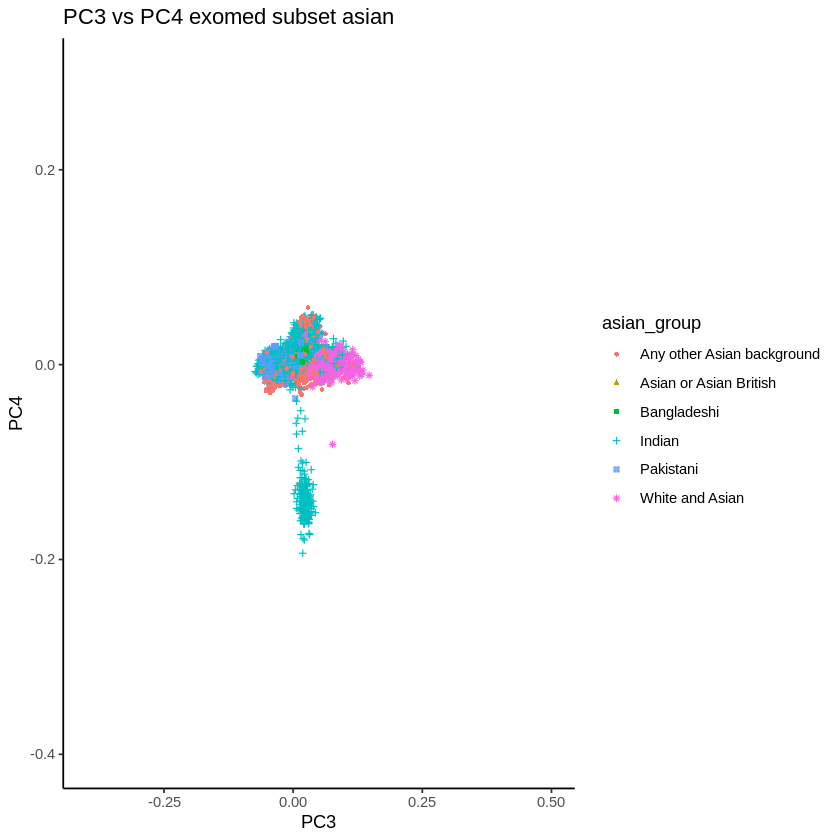

In [160]:
#png('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.pc3vpc4.groups.png', width = 6, height = 4, unit='in', res=300)
ggplot(pca_final_2,aes(x=PC3, y=PC4)) + geom_point(aes(color=asian_group, shape=asian_group), size=1) + labs(title="PC3 vs PC4 exomed subset asian", x="PC3", y="PC4")  + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.4, 0.5)) + theme_classic()
#dev.off()

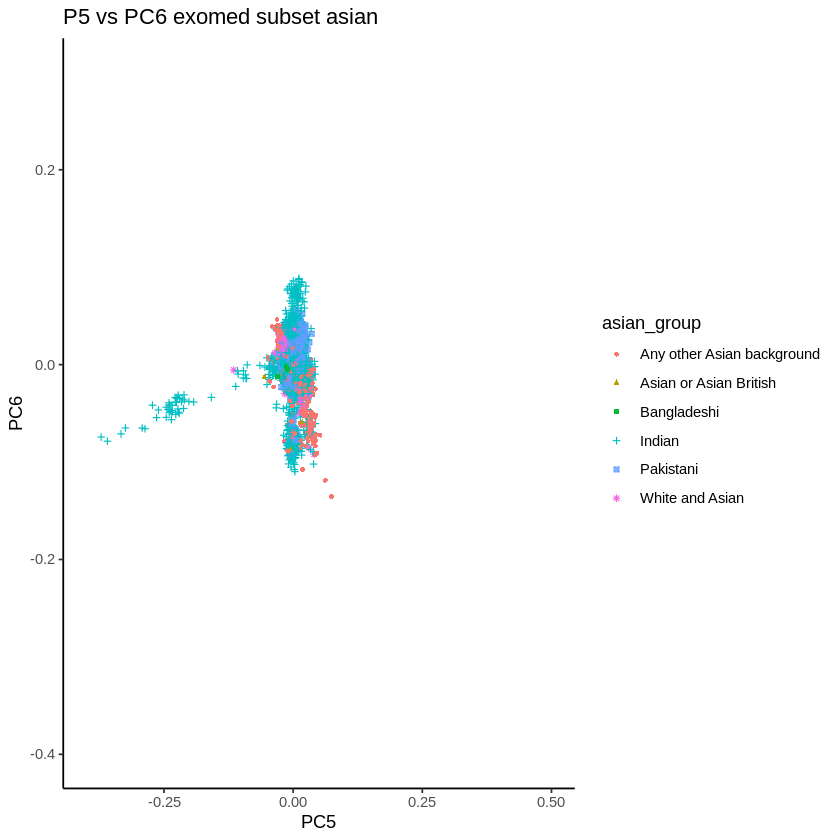

In [161]:
#png('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.pc5vpc6.groups.png', width = 6, height = 4, unit='in', res=300)
ggplot(pca_final_2, aes(x=PC5, y=PC6)) + geom_point(aes(color=asian_group, shape=asian_group), size=1) + labs(title="P5 vs PC6 exomed subset asian",x="PC5", y="PC6")  + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.4, 0.5)) + theme_classic()
#dev.off() 

## Calculate mahalanobis for Asian group

In [81]:
library(dplyr)
pc_2 = pca_final_2 %>%
    select("IID", "asian_group", starts_with("PC"),)
head(pc_2)
nrow(pc_2)

,IID,asian_group,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1003025,Indian,-0.045078438,-0.02351121,-0.03727598,-0.001939958,0.017237348,0.0079387695,0.008515296,-0.012932158,0.046694673,-0.011798214
2,1003083,Indian,0.003444015,0.10163381,0.02795629,-0.139833394,0.012967797,0.0056468977,-0.001013907,0.001144330,-0.003324610,-0.021462816
3,1004223,Pakistani,-0.034232497,-0.01500652,-0.04103763,0.007570796,0.006976456,0.0002015189,0.011007363,0.001573166,0.015790846,-0.011300011
4,1005191,Indian,-0.037983866,-0.02395562,-0.01539751,-0.004815979,-0.008516932,-0.0151500229,-0.014679563,0.004927707,-0.001150084,-0.005391575
5,1005270,Any other Asian background,0.021944835,0.09187301,0.03076726,0.027373091,0.021310332,-0.0078462732,0.002226294,-0.011685237,0.004011084,-0.011672098
6,1005298,Indian,-0.027328636,-0.01706592,-0.03566045,0.004565163,0.003189469,-0.0045964083,-0.012593044,-0.013760497,-0.025179204,-0.052337910


[1] 4618

In [82]:
# calculate covariance of the features
PC_cov_2 = cov(pc_2[,3:12])
head(PC_cov_2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,8.284378e-03,1.187719e-18,-3.808842e-19,5.690349e-21,-1.793673e-19,2.357535e-19,-5.604466e-19,8.592987e-20,-2.849241e-19,-1.085493e-20
PC2,1.187719e-18,4.746530e-03,4.238856e-20,-6.991048e-20,4.632955e-20,-3.693245e-20,-2.551530e-20,9.978015e-20,-1.156542e-19,9.512176e-20
PC3,-3.808842e-19,4.238856e-20,1.250468e-03,4.888920e-19,-7.309389e-20,1.012165e-19,1.282775e-19,-9.379211e-20,3.173349e-19,-9.133989e-20
PC4,5.690349e-21,-6.991048e-20,4.888920e-19,1.120420e-03,3.371485e-20,-1.139738e-19,1.494368e-19,-8.268297e-20,2.001327e-19,-5.655870e-20
PC5,-1.793673e-19,4.632955e-20,-7.309389e-20,3.371485e-20,7.607591e-04,-5.214337e-19,-2.268731e-19,1.022158e-19,2.445987e-19,-6.909890e-20
PC6,2.357535e-19,-3.693245e-20,1.012165e-19,-1.139738e-19,-5.214337e-19,7.342366e-04,-2.216591e-19,1.691071e-19,3.968236e-20,-1.307270e-19


In [83]:
# Find the inverse of the covariance matrix
inv_PC_cov_2 = solve(PC_cov_2)
head(inv_PC_cov_2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,1.207091e+02,-3.020492e-14,3.676718e-14,-6.130531e-16,2.846008e-14,-3.875807e-14,9.462375e-14,-1.469926e-14,5.130478e-14,2.210415e-15
PC2,-3.020492e-14,2.106802e+02,-7.141668e-15,1.314574e-14,-1.283024e-14,1.059732e-14,7.518828e-15,-2.979059e-14,3.634742e-14,-3.380730e-14
PC3,3.676718e-14,-7.141668e-15,7.997003e+02,-3.489469e-13,7.683537e-14,-1.102408e-13,-1.434841e-13,1.062930e-13,-3.785591e-13,1.232238e-13
PC4,-6.130531e-16,1.314574e-14,-3.489469e-13,8.925223e+02,-3.955425e-14,1.385441e-13,-1.865531e-13,1.045795e-13,-2.664562e-13,8.515797e-14
PC5,2.846008e-14,-1.283024e-14,7.683537e-14,-3.955425e-14,1.314477e+03,9.335035e-13,4.171205e-13,-1.904067e-13,-4.796182e-13,1.532254e-13
PC6,-3.875807e-14,1.059732e-14,-1.102408e-13,1.385441e-13,9.335035e-13,1.361959e+03,4.222555e-13,-3.263902e-13,-8.062135e-14,3.003558e-13


In [84]:
# Calculate the mean for each variable
PC_mean_2=apply(pc_2[,3:12], 2, mean)
head(PC_mean_2)

PC1           PC2           PC3           PC4           PC5 
 8.811005e-18  7.951278e-18 -1.730662e-17  1.256495e-17  1.061958e-13 
          PC6 
 1.790854e-12

In [85]:
manha_dis_sq_2 = apply(pc_2[,3:12], 1, FUN=function(x){t(x-PC_mean_2)%*% inv_PC_cov_2 %*% (x-PC_mean_2)})
manha_dis_sq_2

[1]   5.7784815  21.3158401   2.4112024   1.3001360   4.3972346   7.2861437
   [7]   2.1498883   5.1954676  13.0336804   1.2172605  17.2717272  19.1313438
  [13]   4.4980944   2.4611739   1.3726749   8.3503872   5.7838730   0.7421262
  [19]   1.0412637   7.5862083   2.8291983  22.8481748   6.8789235   2.4065393
  [25]  26.7009255   3.7383978  19.4087767   2.7769661   4.9380986   3.6919476
  [31]   7.8800427   3.6994523   1.0477189   1.1630776   5.2516897   1.3368860
  [37]   3.1451192  31.8461702   4.5379112   3.3002036  15.2313601  59.2902851
  [43]   2.1003893   6.1706361   1.6141041   1.1485858   0.8556945   3.3504877
  [49]  12.6709271   3.7154853   3.5650439   8.6321232  20.0698320   5.0562601
  [55]   9.1708747   2.9772451   6.7139723   3.9393263   6.9840000   1.7640622
  [61]   5.4975251   6.9036949   0.9527604   5.0466494  13.9257439   1.4397163
  [67]   1.2516377   2.8915182   2.0060745   4.0843329   2.0071527   1.0723245
  [73]   2.2001159  11.8590326   1.1953694   0.8806799   9.2743621   1.2990853
  [79]  10.7945294   4.2839230   3.8919191   3.5763223   1.7455067   3.2361589
  [85]   4.4900461   8.7014962   5.5325625  14.6090975   1.1438339   4.5940302
  [91]  24.8892852   1.4751349   1.8914553   5.0976791  10.0739708   2.3628100
  [97]   1.0553889  27.1593612   5.1898407  23.0624380   4.7715748   2.0790463
 [103]   1.4417998  79.6205090   6.9024328  22.4153054  23.0326140   3.9489842
 [109]  18.1966923   0.6043324  25.8165030  72.8509672  23.4293795   0.6316430
 [115]   2.6177390  68.8441154   2.4439941   0.8850225  21.7415396   5.1906733
 [121]   3.1282404   4.3745950   4.7853237   2.7680056  21.9259080   4.2337500
 [127]   7.8128375   6.7596739   4.2323425   1.9876531  13.5664891   2.0391448
 [133]   0.8470259   6.0622949  24.1928351   7.6099448   1.4023389   1.8879199
 [139]   4.8209179   2.5241986  47.0788243   2.8915406  64.5289931   7.8866121
 [145]  32.5705072   2.4364717   2.9167848  16.7718875  16.9135302   7.4285882
 [151]   4.9324266   1.3248922   3.2336157   3.0035519   6.1858999   4.6278299
 [157]  24.0654419   4.6433090   5.2821834   2.7896080   1.1568857  17.6721301
 [163]  25.1700600   0.4194014   0.6183726   0.7430081   2.9223306   1.7325750
 [169]   0.4069097   6.5463607   1.9802395   1.0499338   6.6816008   9.0926111
 [175]   1.0832985   3.6607115   2.4807086   3.6161602   4.3452894   3.6292509
 [181]  14.7868626   4.4593444  27.2484917   7.0934706   6.4396779   4.2750890
 [187]   1.7086549  72.7035231   3.4393035  18.3754297  22.1164046   1.4677064
 [193]  94.1467878   0.8647342   6.1041952   3.9874909  31.3771760  10.8223727
 [199]   5.7281330   3.9506118   8.9174727   7.9848388   3.6943797   2.8533357
 [205]  87.3426289   1.4710945   4.2228985   9.3478831  41.7199025   5.3068972
 [211]  22.7851233   1.0716903   2.3557977  10.5058938   3.0858953  27.5385819
 [217]  23.6122257   7.9565882  11.0999966  10.0605211   3.8818881  36.5048163
 [223]   4.3556781  11.0702161   0.4831233   1.5060297   3.5421357   4.2002373
 [229]  18.5714159   5.6213228   4.1442618   1.4320423   8.0866157   6.9138394
 [235]   5.9369198   2.4150098   4.1245748   1.8359963  10.8313203   2.2835638
 [241]   9.7310885   4.9567394   1.5140297   2.4015730   1.5756393  27.2286109
 [247]  23.6843120   3.3098049   1.0782992   3.0337100   5.2493972   6.9418821
 [253]   4.5856748  13.5841475   4.2700102   5.9833558   3.3329944  24.7669906
 [259]   0.6943926   2.4801760  45.8586525   2.0313021   4.3188589   0.5058048
 [265]   2.2939413  48.0187465  31.9399602   6.1138657   6.3607239  11.6873708
 [271]   2.1510665   2.6838089   0.6726933  11.1118019   2.9092817   5.3827357
 [277]  20.2587615   2.0286949   4.7118351   3.2169922   4.4573793   8.8661646
 [283]   2.3764928   2.6851735   0.7702076   5.0912828   5.2826091  13.7042145
 [289]   3.3351494   3.8093717   2.2946283   5.6489438  22.2799311   1.4587631
 [295]   7.6957542   8.8771031   3.9320652   3.8714231   6.9516609   5.5576057
 [301]   2.4618743   4.4896379  89.9777580 114.917454

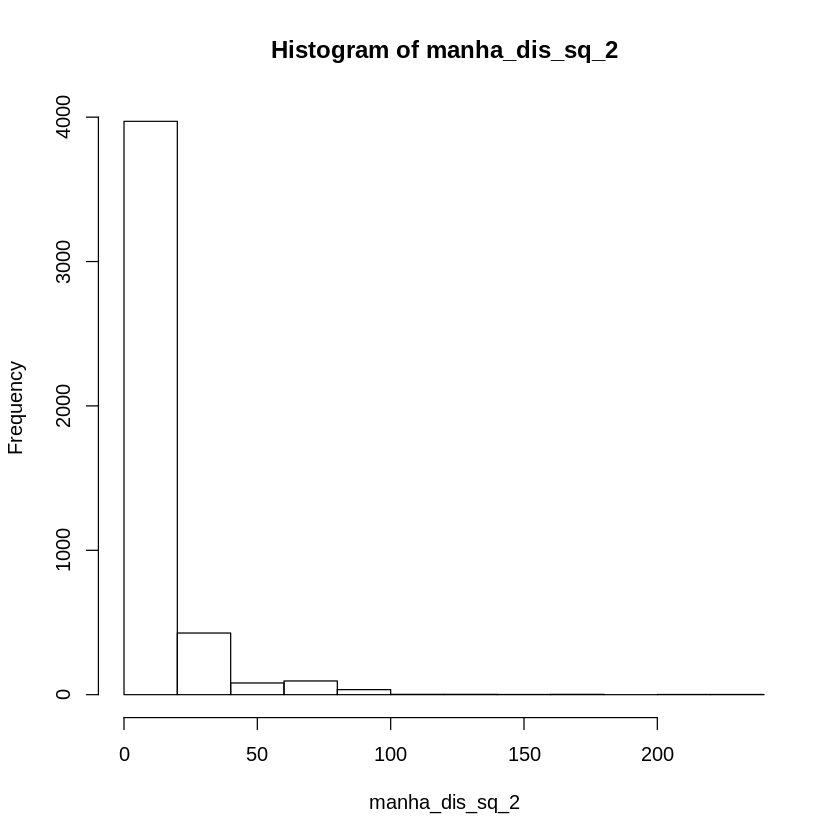

In [86]:
hist(manha_dis_sq_2)

In [87]:
manh_dis_sq_cutoff_2 = quantile(manha_dis_sq_2,probs = 0.95) #6 sd from the mean chi-square double sided
manh_dis_sq_cutoff_2

95% 
36.77314

In [88]:
sd(manha_dis_sq_2)

[1] 15.78401

In [89]:
summary(manha_dis_sq_2)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.2063   2.5690   4.5838   9.9978   9.1128 221.0155 

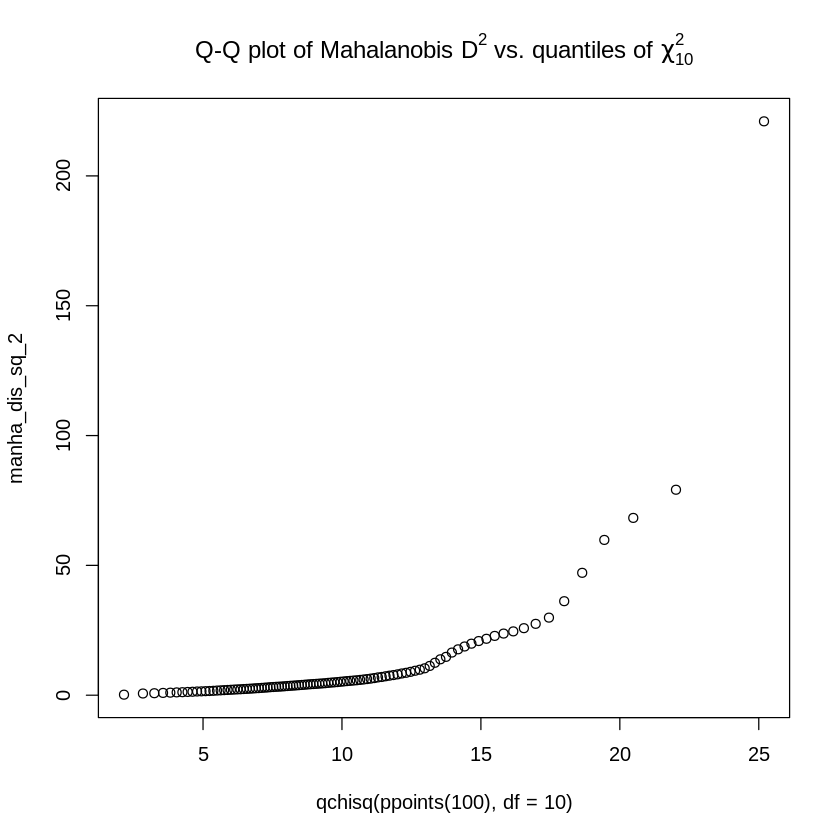

In [90]:
qqplot(qchisq(ppoints(100), df=10), manha_dis_sq_2, main = expression("Q-Q plot of Mahalanobis" * ~D^2 * " vs. quantiles of" * ~ chi[10]^2))

In [91]:
length(which(manha_dis_sq_2 >= manh_dis_sq_cutoff_2))

[1] 231

In [92]:
#Sample without outliers
new_sample_2 = pc_2[(manha_dis_sq_2 <= manh_dis_sq_cutoff_2),1]
length(new_sample_2)
head(new_sample_2)

[1] 4387

[1] 1003025 1003083 1004223 1005191 1005270 1005298

In [93]:
#Outlier_codes
outlier_2 = pc_2[(manha_dis_sq_2 >= manh_dis_sq_cutoff_2),1]
length(outlier_2)

[1] 231

In [94]:
# removed those NAs and inconsistent cases: 
IID_removed_outlier_2<-pca_final_2 %>%
  filter((IID%in%new_sample_2)) %>%
  mutate(FID = IID) %>%
  select(FID, IID, starts_with("PC"), asian_group)
nrow(IID_removed_outlier_2)
head(IID_removed_outlier_2)

[1] 4387

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,asian_group
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1003025,1003025,-0.045078438,-0.02351121,-0.03727598,-0.001939958,0.017237348,0.0079387695,0.008515296,-0.012932158,0.046694673,-0.011798214,Indian
2,1003083,1003083,0.003444015,0.10163381,0.02795629,-0.139833394,0.012967797,0.0056468977,-0.001013907,0.001144330,-0.003324610,-0.021462816,Indian
3,1004223,1004223,-0.034232497,-0.01500652,-0.04103763,0.007570796,0.006976456,0.0002015189,0.011007363,0.001573166,0.015790846,-0.011300011,Pakistani
4,1005191,1005191,-0.037983866,-0.02395562,-0.01539751,-0.004815979,-0.008516932,-0.0151500229,-0.014679563,0.004927707,-0.001150084,-0.005391575,Indian
5,1005270,1005270,0.021944835,0.09187301,0.03076726,0.027373091,0.021310332,-0.0078462732,0.002226294,-0.011685237,0.004011084,-0.011672098,Any other Asian background
6,1005298,1005298,-0.027328636,-0.01706592,-0.03566045,0.004565163,0.003189469,-0.0045964083,-0.012593044,-0.013760497,-0.025179204,-0.052337910,Indian


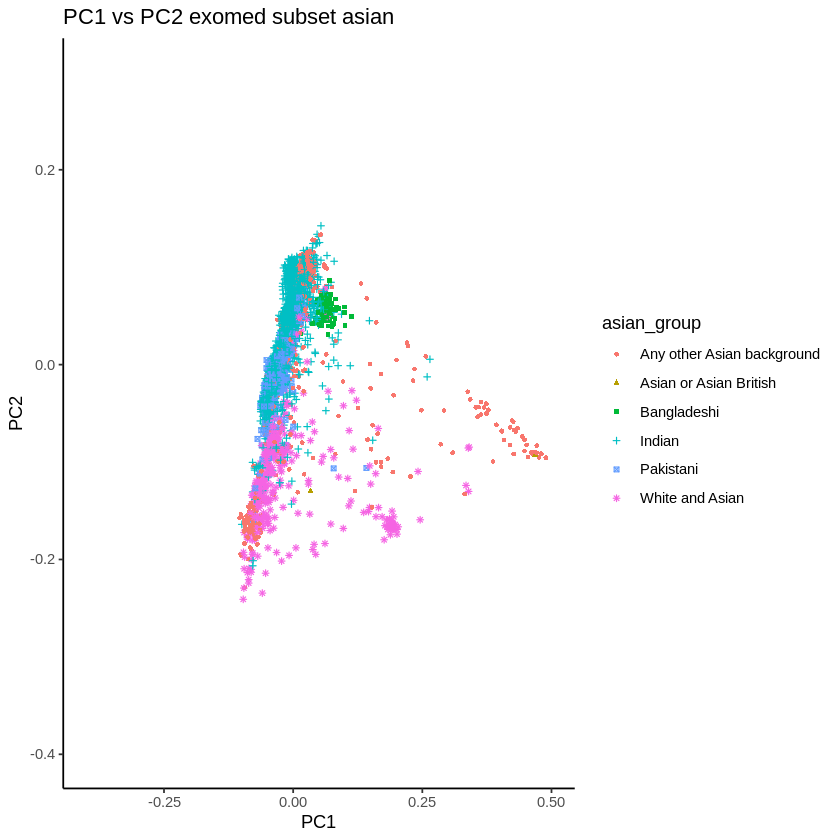

In [162]:
#png('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.pc1vpc2.groups_outrm.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier_2, aes(x=PC1, y=PC2)) + geom_point(aes(color=asian_group, shape=asian_group), size=1) + labs(title="PC1 vs PC2 exomed subset asian",x="PC1", y="PC2") + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.4, 0.5)) + theme_classic()
#dev.off()

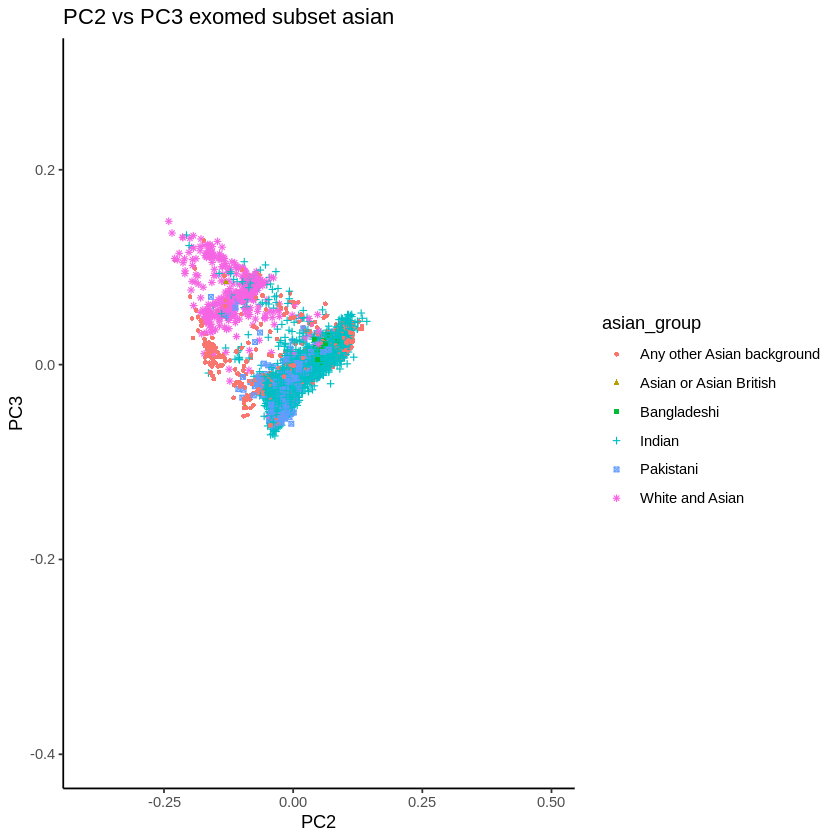

In [163]:
#png('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.pc2vpc3.groups_outrm.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier_2, aes(x=PC2, y=PC3)) + geom_point(aes(color=asian_group, shape=asian_group), size=1) + labs(title="PC2 vs PC3 exomed subset asian", x="PC2", y="PC3") + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.4, 0.5)) + theme_classic()
#dev.off()

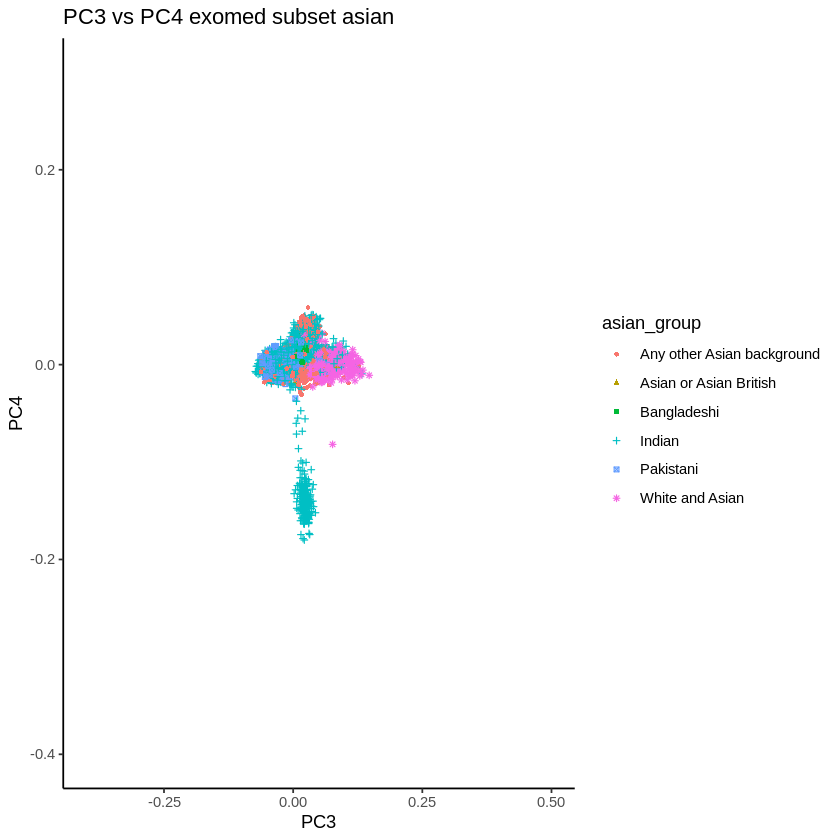

In [164]:
#png('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.pc3vpc4.groups_outrm.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier_2, aes(x=PC3, y=PC4)) + geom_point(aes(color=asian_group, shape=asian_group), size=1) + labs(title="PC3 vs PC4 exomed subset asian", x="PC3", y="PC4") + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.4, 0.5)) + theme_classic()
#dev.off()

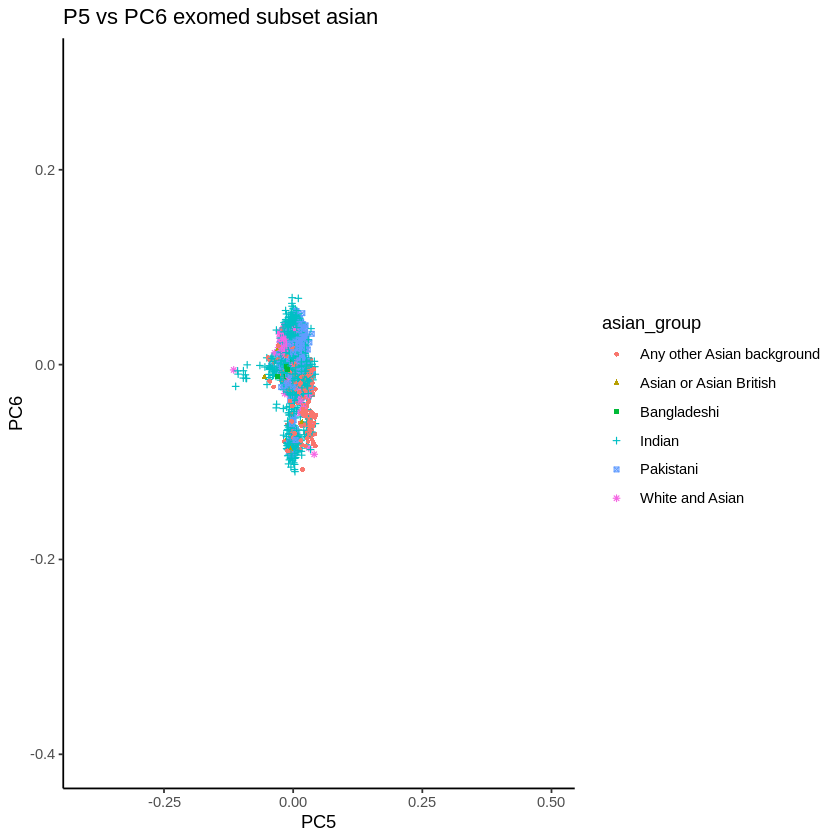

In [165]:
#png('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.pc5vpc6.groups_outrm.png', width = 6, height = 4, unit='in', res=300)
ggplot(IID_removed_outlier_2, aes(x=PC5, y=PC6)) + geom_point(aes(color=asian_group, shape=asian_group), size=1) + labs(title="P5 vs PC6 exomed subset asian",x="PC5", y="PC6") + scale_y_continuous(limits=c(-0.4, 0.3))  + scale_x_continuous(limits=c(-0.4, 0.5)) + theme_classic()
#dev.off() 

## Scree plot: percentage of variance explained Asian ancestry

In [1]:
eigenvalues <- read.table('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.values')
PVE <- eigenvalues[,1]
PVE <- PVE /sum(PVE)
round(PVE, 2)

[1] 0.42 0.24 0.06 0.06 0.04 0.04 0.04 0.04 0.03 0.03

In [2]:
sum(PVE)

[1] 1

In [16]:
library(ggplot2)
# PVE (aka scree) plot
PVEplot <- qplot(c(1:10), PVE) + geom_line() + xlab("Principal Component") + ylab("PVE") + ggtitle("Scree Plot") + ylim(0, 1) +scale_x_discrete(limits=factor(1:10))

In [13]:
PVE_cum <- cumsum(PVE) /sum(PVE)
PVE_cum

[1] 0.4230926 0.6655032 0.7293661 0.7865872 0.8254400 0.8629383 0.8994515
 [8] 0.9354898 0.9697261 1.0000000

In [21]:
cumPVEplot <- qplot(c(1:10), cumsum(PVE)) + geom_line() + xlab("Principal Component") + ylab("PVE") + ggtitle("Cumulative PVE Plot") + ylim(0, 1) + scale_x_discrete(limits=factor(1:10))

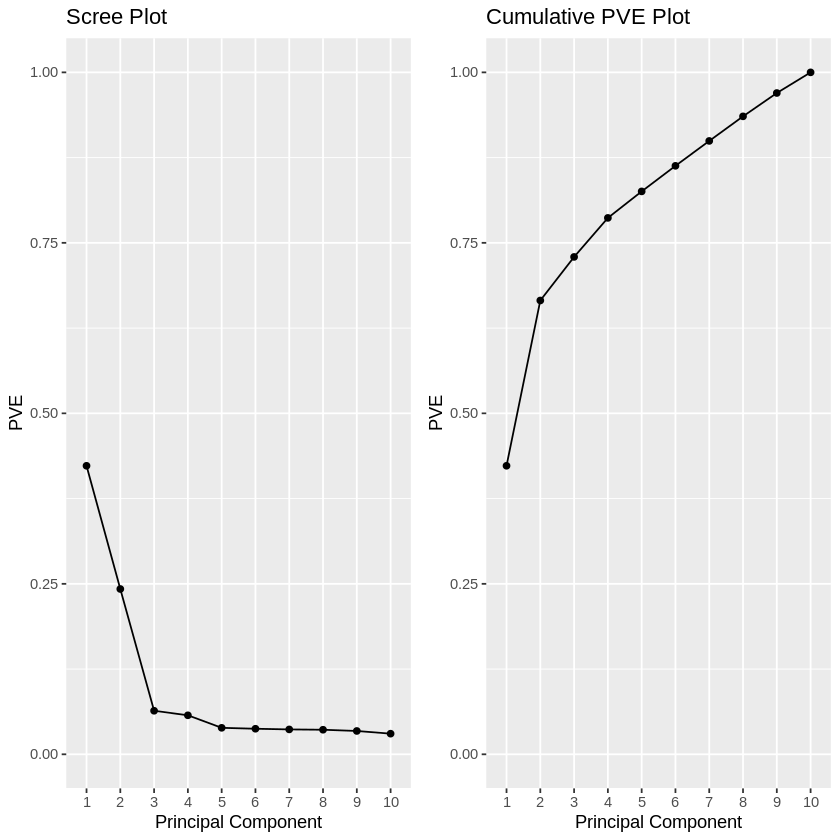

In [22]:
library(gridExtra)
grid.arrange(PVEplot, cumPVEplot, ncol = 2)

In [191]:
eigenvectors <- read.table('/home/dc2325/scratch60/pca/asian_ancestry/ukb23155_s200631.filtered.merged.prune.vectors')

In [192]:
eigenvectors

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1003025:1003025,-0.0072888490,-0.0050223493,-1.551360e-02,-8.529468e-04,0.0091974390,0.0043117665,0.0046868678,-0.0071646780,0.0265418815,-0.0071316452
1003083:1003083,0.0005568716,0.0217105163,1.163492e-02,-6.148094e-02,0.0069193085,0.0030669872,-0.0005580603,0.0006339819,-0.0018897533,-0.0129735903
1004223:1004223,-0.0055351409,-0.0032056182,-1.707914e-02,3.328673e-03,0.0037224713,0.0001094505,0.0060585159,0.0008715658,0.0089757301,-0.0068304974
1005191:1005191,-0.0061417094,-0.0051172812,-6.408172e-03,-2.117455e-03,-0.0045444327,-0.0082283988,-0.0080797156,0.0027300494,-0.0006537234,-0.0032590354
1005270:1005270,0.0035483170,0.0196254612,1.280479e-02,1.203520e-02,0.0113706865,-0.0042615292,0.0012253648,-0.0064738585,0.0022799545,-0.0070554124
1005298:1005298,-0.0044188378,-0.0036455384,-1.484125e-02,2.007178e-03,0.0017018249,-0.0024964372,-0.0069312836,-0.0076235946,-0.0143121988,-0.0316366032
1006702:1006702,-0.0056288687,-0.0025448416,-9.175284e-03,6.620354e-03,0.0002871296,0.0079717951,-0.0023919388,0.0038713511,-0.0032295245,-0.0143073432
1007904:1007904,-0.0071902449,-0.0038778138,-9.200932e-03,-4.853487e-03,-0.0014961381,0.0109789020,-0.0009024084,-0.0060744176,-0.0132030426,-0.0248099146
1011060:1011060,0.0301673563,-0.0337872249,1.727420e-02,-4.392132e-03,-0.0110154791,0.0041299328,0.0004872984,-0.0111612849,-0.0119056400,0.0069776983


## Projecting PCA 

In [5]:
library(flashpcaR)
data(hm3.chr1)

In [7]:
fn <- gsub("\\.bed", "",system.file("extdata", "data_chr1.bed", package="flashpcaR"))

In [8]:
f <- flashpca(fn, ndim=10, stand="binom2", do_loadings=TRUE, check_geno=TRUE)

2431:NA19916,-0.1588109,0.11228930,-0.0252563429,0.07033462,-0.006955226,-0.06637111,0.010728934,0.024002409,-0.05373867,4.367597e-02
2424:NA19835,-0.1853581,0.05984351,-0.0572537974,0.07373645,-0.013861114,0.02275922,-0.000546114,-0.039609570,-0.08675227,-9.125711e-05
2469:NA20282,-0.1590793,0.02471908,-0.0094153496,0.07736482,0.042594775,0.05044218,-0.051205706,-0.090104593,0.06367886,5.100796e-02
2368:NA19703,-0.1315415,0.04551456,-0.0310594509,0.08752782,-0.026674915,-0.02686750,-0.013326077,-0.004980057,-0.03869854,1.527154e-01
2425:NA19901,-0.1257463,0.13985541,0.0069868991,0.07034874,-0.012788124,-0.11412937,0.021301304,0.091128348,-0.05436430,3.005186e-02
2427:NA19908,-0.1635864,0.12852679,0.0005360202,0.16094435,-0.029543941,-0.02682772,0.010645595,0.061242396,-0.05020259,8.532583e-02


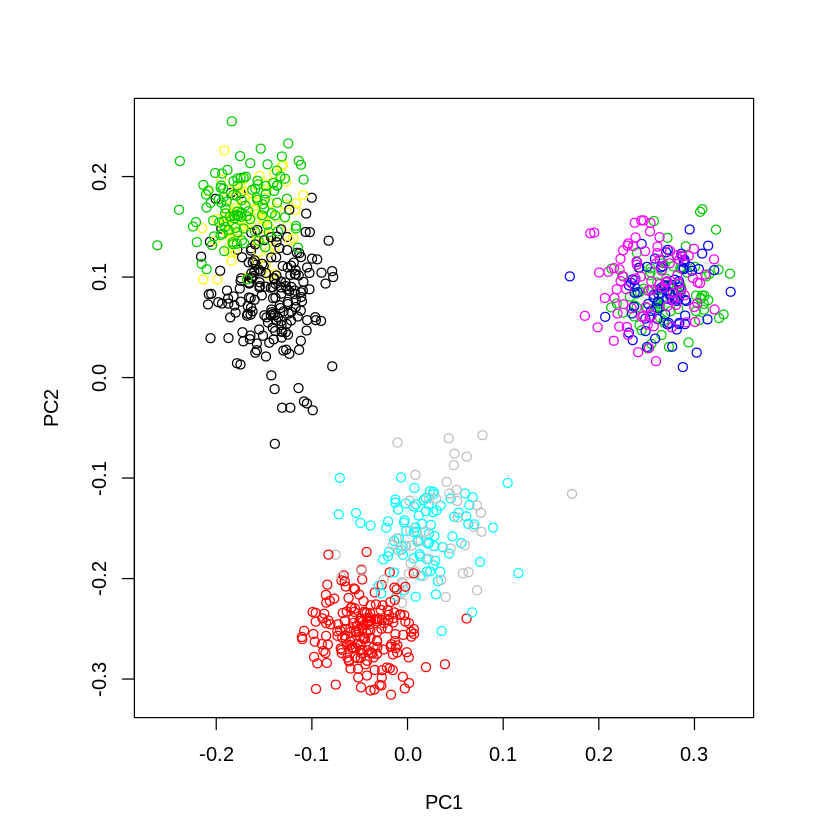

In [9]:
ref <- hm3.chr1$bim[,5]
names(ref) <- hm3.chr1$bim[,2]
P3 <- project(fn, loadings=f$loadings,orig_mean=f$center, orig_sd=f$scale, ref_alleles=ref)
head(P3$projection)
par(pty="s")
plot(P3$projection[, 1:2], col=factor(hm3.chr1$population$population),xlab="PC1", ylab="PC2")

## Projecting PCA on MWE

In [ ]:
MWE_PATH=/gpfs/gibbs/pi/dewan/data/UKBiobank/MWE
sos run ~/project/bioworkflows/GWAS/PCA.ipynb flashpca:1\
    --cwd ~/output \
    --bfile $MWE_PATH/burden/genotypes_21_22_plink.exome.bed \
    --genoFile $MWE_PATH/burden/ukb23155_c2*_b0_v1.plink.exome.filtered.bed \
    --phenoFile $MWE_PATH/burden/phenotype_burden_pca.txt \
    --keep_samples $MWE_PATH/burden/unrelated_ind_burden.txt \
    --k 10 \
    --window 50 \
    --shift 10 \
    --r2 0.5 \
    --maf_filter 0.5 \
    --geno_filter 0.2 \
    --mind_filter 0. \
    --hwe_filter 0.0\
    --trait_name ethnicity \
    --numThreads 1 \
    --job_size 1 \
    --container_lmm /gpfs/gibbs/pi/dewan/data/UKBiobank/lmm.sif

In [12]:
fn <- '/gpfs/gibbs/pi/dewan/data/UKBiobank/MWE/burden/genotypes_21_22_plink.exome'

In [13]:
f <- flashpca(fn, ndim=10, stand="binom2", do_loadings=TRUE, check_geno=TRUE)

In [17]:
f$scale

[1] 0.19798990 0.70707142 0.19847656 0.19896682 0.68373058 0.70709785
    [7] 0.52171592 0.23127365 0.65692465 0.20973197 0.70696535 0.40974077
   [13] 0.23127365 0.38997371 0.49794578 0.31616388 0.30822070 0.25077380
   [19] 0.66369232 0.47560488 0.70558104 0.70709794 0.24124676 0.70110627
   [25] 0.24242424 0.20973197 0.62983666 0.38908547 0.59055059 0.25077380
   [31] 0.69490107 0.69608420 0.35563194 0.51711026 0.44249294 0.69910657
   [37] 0.62040064 0.69799713 0.33585711 0.34232660 0.69670970 0.50497525
   [43] 0.25138188 0.58064337 0.45956501 0.38454526 0.70110627 0.38908547
   [49] 0.26997772 0.17232591 0.55800634 0.23127365 0.27712813 0.58099053
   [55] 0.47168581 0.33664591 0.27712813 0.54624857 0.66105030 0.64171645
   [61] 0.39439828 0.49071377 0.70667355 0.70652350 0.62600919 0.61029664
   [67] 0.54332311 0.19798990 0.26867732 0.23127365 0.20973197 0.23183754
   [73] 0.51181051 0.20973197 0.69057042 0.14071247 0.63146655 0.15712256
   [79] 0.21024612 0.63540383 0.30152847 0.59601994 0.70311846 0.57958022
   [85] 0.18543867 0.26867732 0.40974077 0.59844373 0.55198505 0.12201434
   [91] 0.20973197 0.57852182 0.60066544 0.69477700 0.69477700 0.40974077
   [97] 0.19798990 0.45539818 0.19798990 0.38908547 0.48701899 0.47946585
  [103] 0.20973197 0.65406422 0.55757287 0.58448282 0.66749532 0.47661932
  [109] 0.24124676 0.09974969 0.48327011 0.68730452 0.69910657 0.60182016
  [115] 0.44686407 0.68084506 0.34864022 0.42426407 0.32999813 0.61837489
  [121] 0.45956501 0.70710678 0.33585711 0.65350788 0.51391216 0.25990383
  [127] 0.62032250 0.38997371 0.21076406 0.59286381 0.48327011 0.62785349
  [133] 0.22079402 0.25077380 0.24183336 0.34232660 0.22133382 0.50252513
  [139] 0.23127365 0.18543867 0.41950864 0.22079402 0.24124676 0.23240556
  [145] 0.12231821 0.69681418 0.22079402 0.35563194 0.44686407 0.28528495
  [151] 0.20973197 0.22079402 0.20973197 0.37813688 0.55863714 0.30081140
  [157] 0.57602083 0.69282032 0.49794578 0.38908547 0.25077380 0.47560488
  [163] 0.47560488 0.44346556 0.49071377 0.20973197 0.51181051 0.49538921
  [169] 0.32317458 0.21076406 0.37813688 0.26932517 0.45116516 0.70559635
  [175] 0.31541639 0.56031241 0.07062223 0.69133928 0.44249294 0.17190113
  [181] 0.50497525 0.69133928 0.29317230 0.67882251 0.60066544 0.20973197
  [187] 0.70281577 0.28528495 0.22079402 0.38908547 0.64006836 0.15751184
  [193] 0.53122500 0.68814969 0.23127365 0.70707071 0.70707142 0.66105030
  [199] 0.46366745 0.19847656 0.15790402 0.23240556 0.41466854 0.55198505
  [205] 0.23127365 0.17190113 0.15712256 0.70561144 0.40472213 0.59740062
  [211] 0.43545781 0.37813688 0.18543867 0.60182016 0.15790402 0.70236805
  [217] 0.15712256 0.45539818 0.19798990 0.22079402 0.61237244 0.70696535
  [223] 0.12201434 0.46770717 0.49011723 0.69681418 0.24124676 0.61640084
  [229] 0.14106200 0.56831989 0.69955813 0.66498120 0.48327011 0.61837489
  [235] 0.18543867 0.37335026 0.42426407 0.63244755 0.59286381 0.26867732
  [241] 0.70535474 0.67531407 0.30822070 0.64102367 0.58342737 0.70688578
  [247] 0.19798990 0.40974077 0.66369232 0.54438603 0.54624857 0.70639047
  [253] 0.53735463 0.55757287 0.35563194 0.52171592 0.64128372 0.43804965
  [259] 0.52915551 0.19798990 0.46366745 0.17190113 0.18543867 0.25077380
  [265] 0.51181051 0.54248866 0.70056812 0.70678851 0.21024612 0.35027355
  [271] 0.33585711 0.45214962 0.37813688 0.60612499 0.25990383 0.23127365
  [277] 0.31541639 0.66832282 0.26867732 0.31541639 0.53021885 0.32922257
  [283] 0.51515774 0.34864022 0.41466854 0.58583274 0.34864022 0.23127365
  [289] 0.38366652 0.50601792 0.24183336 0.34864022 0.70583284 0.55411890
  [295] 0.23127365 0.12231821 0.70688129 0.24124676 0.70319805 0.70454773
  [301] 0.30822070 0.34945404 0.66238206 0.30081140 0.52915551 0.34232660
  [307] 0.23127365 0.42893764 0.15712256 0.46366745 0.14071247 0.14106200
  [313] 0.70007232 0.61440011 0.57412043 0.44686407 0.17190113 0.66454318
  [319] 0.19798990 0.25138188 0.51515774 0.18543867 0.32317458 0.32241278
  [325] 

In [18]:
P3 <- project(fn, loadings=f$loadings,orig_mean=f$center, orig_sd=f$scale)

ERROR: Error in project(fn, loadings = f$loadings, orig_mean = f$center, orig_sd = f$scale): orig_sd cannot be zero or negative


In [90]:
fn <- '/home/dc2325/output/phenotype_burden_pca.filtered.merged.prune'
# Do the PCA computation
f <- flashpca(fn, ndim=10, stand="binom2", do_loadings=TRUE, check_geno=TRUE)

In [91]:
f$values

[1] 23.545348 21.075806 18.284320 17.237030 15.422310 14.289990 13.222638
 [8] 10.775783  9.650069  9.062754

In [22]:
eigenvalues <- f$values
PVE <- f$values
PVE <- round(PVE/sum(PVE), 2)

In [23]:
PVE

[1] 0.15 0.14 0.12 0.11 0.11 0.10 0.08 0.07 0.06 0.06

In [92]:
saveRDS(f, '~/output/test.rds')

In [93]:
f_new <- readRDS('~/output/test.rds')

In [95]:
rm(list = ls())

In [96]:
f <- readRDS('~/output/phenotype_burden_pca.filtered.merged.prune.rds')

In [97]:
str(f)

List of 7
 $ values    : num [1:10] 23.5 21.1 18.3 17.2 15.4 ...
 $ vectors   : num [1:150, 1:10] -0.0768 -0.0725 0.0485 -0.1209 -0.0734 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:150] "1000035:1000035" "1000078:1000078" "1000198:1000198" "1000236:1000236" ...
  .. ..$ : NULL
 $ projection: num [1:150, 1:10] -0.373 -0.352 0.235 -0.587 -0.356 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:150] "1000035:1000035" "1000078:1000078" "1000198:1000198" "1000236:1000236" ...
  .. ..$ : NULL
 $ loadings  : num [1:10, 1:10] -0.0787 0.1366 0.1429 -0.5153 -0.4578 ...
 $ center    : num [1:10] 0.986 0.978 1 1 0.98 ...
 $ scale     : num [1:10] 0.707 0.707 0.707 0.707 0.707 ...
 $ pve       : num [1:10] 0.154 0.138 0.12 0.113 0.101 ...
 - attr(*, "class")= chr "flashpca"


In [148]:
# Read the PLINK binary files
frel <-'/home/dc2325/output/phenotype_burden_pca.filtered.merged.prune.related_id'
# Project related samples
fpro <- project(frel, loadings=f$loadings, orig_mean=f$center, orig_sd=f$scale, ref_allele=ref)

In [155]:
df <- do.call(rbind.data.frame, ftotal)

ERROR: Error in do.call(rbind.data.frame, ftotal): second argument must be a list


In [150]:
fpro

$projection
                        [,1]         [,2]         [,3]        [,4]        [,5]
1000210:1000210 -0.264551593 -0.397564197 -0.137314529  0.42377546  0.31922338
1000516:1000516  0.228390344  0.343159664  0.129474409  0.02235255 -0.31133450
1000642:1000642 -0.023839983  0.237818118  0.097671317 -0.22969772  0.33926895
1000683:1000683 -0.382530861  0.005081906  0.009688434 -0.21434280  0.27740660
1001351:1001351  0.205595274  0.099169260  0.152776678 -0.22737584  0.03754305
1001420:1001420  0.275219802  0.110253915 -0.399940115 -0.15023806  0.04337510
1001897:1001897  0.122428649 -0.662032531 -0.301370676 -0.06284881  0.03177693
1002859:1002859 -0.353853800  0.071310371 -0.471411022  0.09057380 -0.09797184
1003042:1003042  0.174934016 -0.494536000  0.507063396  0.20590311  0.32644620
1003512:1003512  0.242507127 -0.589437706 -0.214444003  0.12441935 -0.25179299
1014688:1014688 -0.170117065 -0.158979875 -0.055119975  0.38957377 -0.33600749
1050929:1050929  0.106264899 -0.54290805

In [184]:
head(df)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
projection.1000210:1000210,-0.26455159,-0.397564197,-0.137314529,0.42377546,0.31922338,-0.23033743,-0.03563406,0.032805335,-0.09661532,0.06598739
projection.1000516:1000516,0.22839034,0.343159664,0.129474409,0.02235255,-0.31133450,0.41268857,0.18802793,0.337570050,0.25991158,0.37492673
projection.1000642:1000642,-0.02383998,0.237818118,0.097671317,-0.22969772,0.33926895,0.40436460,-0.21035315,-0.791299805,0.21116457,0.28708235
projection.1000683:1000683,-0.38253086,0.005081906,0.009688434,-0.21434280,0.27740660,0.41394580,-0.21350382,0.046830117,-0.17239071,-0.30954865
projection.1001351:1001351,0.20559527,0.099169260,0.152776678,-0.22737584,0.03754305,-0.04820695,0.12834424,-0.007538517,-0.01656586,-0.21160595
projection.1001420:1001420,0.27521980,0.110253915,-0.399940115,-0.15023806,0.04337510,0.47736545,-0.13626016,0.236426861,-0.22413111,-0.02436425


In [ ]:
#Combine matrices

ftotal <- rbind(f$projection, fpro$projection)
ftotal

In [194]:
typeof(ftotal)

[1] "double"

In [207]:
#min_axis <- round(apply(ftotal_new[2:10], 2, min),1)
min_axis <- round(colMins(as.matrix(ftotal_new[2:10][sapply(ftotal_new[2:10], is.numeric)])),1)
min_axis

[1] -1.0 -0.8 -0.9 -0.9 -0.8 -0.9 -0.8 -0.8 -0.6

In [187]:
library(tidyverse)
ftotal_new <- ftotal.df %>% 
  rownames_to_column(var = "ID")
head(ftotal_new)

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000035:1000035,-0.3728710,0.48272708,0.83412563,0.51480728,-0.09755235,-0.09124341,-0.096955311,-0.4619047,-0.01398885,-0.04950232
2,1000078:1000078,-0.3515841,0.51834096,-0.17147272,-0.16019650,0.26751924,-0.14531295,0.481047942,0.2150432,-0.14937821,0.38054710
3,1000198:1000198,0.2352627,0.51309792,0.06036764,-0.08314001,0.46453151,0.12782756,0.402501962,-0.6629927,-0.10223678,0.05915844
4,1000236:1000236,-0.5867287,-0.03612449,0.22768577,-0.67548848,-0.11992926,-0.08820921,0.220149328,0.1752739,0.05465517,-0.48446141
5,1000291:1000291,-0.3562968,-0.36588683,-0.35176964,0.17747869,0.44339217,0.39781368,-0.043151226,0.1841793,0.06319805,-0.09411710
6,1000340:1000340,0.9885921,-0.20248400,-0.03561681,-0.13931718,0.01627169,-0.06244091,0.008328207,-0.3342183,-0.17279729,0.11507322


In [167]:
ftotal.df <-  as.data.frame(ftotal)

In [163]:
names(ftotal.df)

[1] "V1"  "V2"  "V3"  "V4"  "V5"  "V6"  "V7"  "V8"  "V9"  "V10"

In [188]:
colnames(ftotal_new) <- c("ID",paste0("PC", 1:10))

In [189]:
ftotal_new

ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000035:1000035,-0.37287096,0.482727079,0.83412563,0.514807280,-0.09755235,-0.09124341,-0.0969553108,-0.46190470,-0.01398885,-0.0495023191
1000078:1000078,-0.35158410,0.518340959,-0.17147272,-0.160196504,0.26751924,-0.14531295,0.4810479423,0.21504317,-0.14937821,0.3805470952
1000198:1000198,0.23526265,0.513097920,0.06036764,-0.083140009,0.46453151,0.12782756,0.4025019615,-0.66299273,-0.10223678,0.0591584368
1000236:1000236,-0.58672871,-0.036124492,0.22768577,-0.675488484,-0.11992926,-0.08820921,0.2201493278,0.17527390,0.05465517,-0.4844614075
1000291:1000291,-0.35629683,-0.365886828,-0.35176964,0.177478689,0.44339217,0.39781368,-0.0431512256,0.18417925,0.06319805,-0.0941171045
1000340:1000340,0.98859208,-0.202483997,-0.03561681,-0.139317183,0.01627169,-0.06244091,0.0083282070,-0.33421827,-0.17279729,0.1150732231
1000357:1000357,0.06384358,0.245014513,0.18573539,-0.162108154,0.17321913,0.07428704,-0.3948932969,0.37047608,0.71366425,0.2009273421
1000421:1000421,-0.01183419,-0.548097868,0.28817700,0.475288543,0.19622142,0.31060656,-0.4997222863,0.06248433,-0.15311295,0.0129172860
1000494:1000494,-0.54859843,0.454723889,-0.40393872,0.258841977,-0.13511938,0.23343406,-0.1140822758,-0.35570602,0.21236462,-0.0793238841


In [190]:
ftotal_new$IID <- sapply(strsplit(as.character(ftotal_new$ID),':'), "[", 1)

In [191]:
ftotal_new

ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,IID
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1000035:1000035,-0.37287096,0.482727079,0.83412563,0.514807280,-0.09755235,-0.09124341,-0.0969553108,-0.46190470,-0.01398885,-0.0495023191,1000035
1000078:1000078,-0.35158410,0.518340959,-0.17147272,-0.160196504,0.26751924,-0.14531295,0.4810479423,0.21504317,-0.14937821,0.3805470952,1000078
1000198:1000198,0.23526265,0.513097920,0.06036764,-0.083140009,0.46453151,0.12782756,0.4025019615,-0.66299273,-0.10223678,0.0591584368,1000198
1000236:1000236,-0.58672871,-0.036124492,0.22768577,-0.675488484,-0.11992926,-0.08820921,0.2201493278,0.17527390,0.05465517,-0.4844614075,1000236
1000291:1000291,-0.35629683,-0.365886828,-0.35176964,0.177478689,0.44339217,0.39781368,-0.0431512256,0.18417925,0.06319805,-0.0941171045,1000291
1000340:1000340,0.98859208,-0.202483997,-0.03561681,-0.139317183,0.01627169,-0.06244091,0.0083282070,-0.33421827,-0.17279729,0.1150732231,1000340
1000357:1000357,0.06384358,0.245014513,0.18573539,-0.162108154,0.17321913,0.07428704,-0.3948932969,0.37047608,0.71366425,0.2009273421,1000357
1000421:1000421,-0.01183419,-0.548097868,0.28817700,0.475288543,0.19622142,0.31060656,-0.4997222863,0.06248433,-0.15311295,0.0129172860,1000421
1000494:1000494,-0.54859843,0.454723889,-0.40393872,0.258841977,-0.13511938,0.23343406,-0.1140822758,-0.35570602,0.21236462,-0.0793238841,1000494


In [185]:
df[grepl("projection^", df), ]

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [108]:
bim <- read.table('~/output/phenotype_burden_pca.filtered.merged.prune.related_id.bim')

In [101]:
head(bim)

,V1,V2,V3,V4,V5,V6
,<int>,<fct>,<int>,<int>,<fct>,<fct>
1,21,21:14521273:T:C,0,14521273,C,T
2,21,21:37090659:T:A,0,37090659,A,T
3,21,21:46001401:C:T,0,46001401,T,C
4,22,22:19452017:G:A,0,19452017,G,A
5,22,22:20859092:C:T,0,20859092,C,T
6,22,22:24323117:C:G,0,24323117,G,C


In [125]:
ref <- as.character(bim[,5])
names(ref) <- bim[,2]

In [126]:
ref

21:14521273:T:C 21:37090659:T:A 21:46001401:C:T 22:19452017:G:A 22:20859092:C:T 
            "C"             "A"             "T"             "G"             "C" 
22:24323117:C:G 22:33626300:G:A 22:42882156:T:C 22:43826927:A:C 22:49962626:C:T 
            "G"             "G"             "C"             "C"             "T"

In [127]:
names(ref)

[1] "21:14521273:T:C" "21:37090659:T:A" "21:46001401:C:T" "22:19452017:G:A"
 [5] "22:20859092:C:T" "22:24323117:C:G" "22:33626300:G:A" "22:42882156:T:C"
 [9] "22:43826927:A:C" "22:49962626:C:T"

In [128]:
ref

21:14521273:T:C 21:37090659:T:A 21:46001401:C:T 22:19452017:G:A 22:20859092:C:T 
            "C"             "A"             "T"             "G"             "C" 
22:24323117:C:G 22:33626300:G:A 22:42882156:T:C 22:43826927:A:C 22:49962626:C:T 
            "G"             "G"             "C"             "C"             "T"

In [129]:
typeof(ref)

[1] "character"